In [75]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import warnings
import tqdm
import time
warnings.filterwarnings("ignore")

# Class

In [109]:
class ActivationNetwork:
    def __init__(self, N=70, alpha=2.2, lambda_=1.0, noise_std=0.03, dt=1, T=50, input_size = 5, input_level = 0.334):
        self.N = N
        self.alpha = alpha
        self.lambda_ = lambda_
        self.noise_std = noise_std
        self.dt = dt
        self.num_steps = T
        self.input_level = input_level
        self.input_size = input_size
        self.epsilon = 1e-8
    
    def F(self, x, type='rational sigmoid', threshold=0.2, slope=0.5):
        if type == 'rational sigmoid':
            return np.where(x > 0, x / (1 + x), 0)
        elif type == 'threshold':
            return np.where(x > threshold, 1, 0)
        elif type == 'tanh':
            return np.tanh(x)
        elif type == 'linear':
            return x * slope
        elif type == 'relu':
            return np.where(x > 0, x, 0)
        elif type == 'sigmoid':
            return 1 / (1 + np.exp(-x)) - 1/2
        else:
            raise ValueError('Invalid activation function type\nValid types are: \nrational sigmoid\nthreshold\ntanh\nlinear\nrelu\nsigmoid')
            
    def run_simulation(self, beta, set_size, type='rational sigmoid'):
        x = np.zeros(self.N)
        # x = np.random.rand(self.N)
        x_t = np.zeros((self.num_steps, self.N))

        I = np.zeros(self.N)
        I[:set_size] = self.input_level

        for step in range(self.num_steps):
            if step >= self.input_size:
                I[:set_size] = 0

            for i in range(self.N):
                interaction_sum = np.sum(self.F(x[j]) for j in range(self.N) if j != i)
                # noise = 0
                noise = np.random.normal(0, self.noise_std)
                
                # x[i] = max((1-self.dt) * x[i] + self.dt * (self.alpha * self.F(x[i]) - beta * interaction_sum + I[i] + noise), 0)
                # x[i] = (1-self.dt) * x[i] + self.dt * (self.alpha * self.F(x[i]) - beta * interaction_sum + I[i] + noise)
                x[i] = max((1-self.dt) * x[i] + self.dt * (self.alpha * self.F(x[i], type) - beta * interaction_sum + I[i] + noise), 0)
            
            x_t[step, :] = x

        # plt.plot(x_t)
        # plt.xlabel('Time Steps')
        # plt.ylabel('Activation Levels')
        # plt.title('Activation Levels Over Time')
        # plt.show()
        
        # print(x_t[-1])

        return np.mean(x_t[-1, :])
    
    def run_simulation_with_graph(self, beta, set_size, type='rational sigmoid'):
        x = np.zeros(self.N)
        # x = np.random.rand(self.N)
        x_t = np.zeros((self.num_steps, self.N))

        I = np.zeros(self.N)
        I[:set_size] = self.input_level

        for step in range(self.num_steps):
            if step >= self.input_size:
                I[:set_size] = 0

            for i in range(self.N):
                interaction_sum = np.sum(self.F(x[j]) for j in range(self.N) if j != i)
                # noise = 0
                noise = np.random.normal(0, self.noise_std)
                
                # x[i] = max((1-self.dt) * x[i] + self.dt * (self.alpha * self.F(x[i]) - beta * interaction_sum + I[i] + noise), 0)
                # x[i] = (1-self.dt) * x[i] + self.dt * (self.alpha * self.F(x[i]) - beta * interaction_sum + I[i] + noise)
                x[i] = max((1-self.dt) * x[i] + self.dt * (self.alpha * self.F(x[i], type) - beta * interaction_sum + I[i] + noise), 0)
            
            x_t[step, :] = x

        plt.plot(x_t)
        plt.xlabel('Time Steps')
        plt.ylabel('Activation Levels')
        plt.title('Activation Levels Over Time')
        plt.show()
        
        # print(x_t[-1])

        return np.mean(x_t[-1, :])
    
    def get_hamming_distance(self, beta, set_size, type='rational sigmoid'):
        x = np.zeros(self.N)
        x_t = np.zeros((self.num_steps, self.N))
        I = np.zeros(self.N)
        I[:set_size] = self.input_level
        for step in range(self.num_steps):
            if step >= self.input_size:
                I[:set_size] = 0
            for i in range(self.N):
                interaction_sum = np.sum(self.F(x[j]) for j in range(self.N) if j != i)
                noise = np.random.normal(0, self.noise_std)
                x[i] = max((1-self.dt) * x[i] + self.dt * (self.alpha * self.F(x[i],type) - beta * interaction_sum + I[i] + noise), 0)
            x_t[step, :] = x

        # plt.plot(x_t)
        # plt.xlabel('Time Steps')
        # plt.ylabel('Activation Levels')
        # plt.title('Activation Levels Over Time')
        # plt.show()
        
        # print(x_t[-1])
        
        I[:set_size] = self.input_level
        x_t = np.where(x_t > 0.1, 1, 0)
        I = np.where(I > 0.1, 1, 0)
        hamming_distance = np.sum(np.abs(I - x_t[-1, :]))
        return hamming_distance
    
    def get_rt(self, beta, set_size):
        x = np.zeros(self.N)
        x_t = np.zeros((self.num_steps, self.N))
        x_dot = np.zeros(self.N)
        I = np.zeros(self.N)
        I[:set_size] = self.input_level
        total_energy = 0
        total_reaction_time = 0
        for step in range(self.num_steps):
            if step >= self.input_size:
                I[:set_size] = 0
            dx = np.zeros(self.N)
            for i in range(self.N):
                interaction_sum = np.sum(self.F(x[j]) for j in range(self.N) if j != i)
                noise = np.random.normal(0, self.noise_std)
                x[i] = max((1-self.dt) * x[i] + self.dt * (self.alpha * self.F(x[i]) - beta * interaction_sum + I[i] + noise), 0)
                dx[i] = -self.lambda_ * x[i] + self.alpha * self.F(x[i]) - beta * interaction_sum + I[i] + noise
                x_dot[i] = dx[i] / self.dt
                fluctuation_energy = (1 - self.alpha * (self.F(x[i]) / x[i])**2) * x_dot[i]**2 if x[i] != 0 else 0
                total_energy += fluctuation_energy * self.dt
                total_reaction_time += fluctuation_energy * self.dt
            x_t[step, :] = x
        return np.mean(x_t[-1, :]), abs(total_energy), abs(total_reaction_time)

    def find_mean_activation(self, beta, set_size, num_simulations=100, type='rational sigmoid'):
        avg_activation = 0
        for _ in range(num_simulations):
            avg_activation += self.run_simulation(beta, set_size, type) / num_simulations
        return avg_activation
    
    def find_mean_hamming_distance(self, beta, set_size, num_simulations=100, type='rational sigmoid'):
        avg_activation = 0
        for _ in range(num_simulations):
            avg_activation += self.get_hamming_distance(beta, set_size, type) / num_simulations
        return avg_activation
    
    def find_prob_larger_response(self, beta, set_size, num_simulations=100, const_set_size=16, threshold=0.01):
        num_larger_responses = 0
        for _ in range(num_simulations):
            response1 = self.run_simulation(beta, set_size)
            response2 = self.run_simulation(beta, const_set_size)
            if response1 - response2 > threshold:
                num_larger_responses += 1
        return num_larger_responses / num_simulations
    
    def find_mean_rt(self, beta, set_size, num_simulations=100):
        avg_activation = 0
        avg_energy = 0
        avg_reaction_time = 0
        for _ in range(num_simulations):
            activation, energy, reaction_time = self.get_rt(beta, set_size)
            avg_activation += activation / num_simulations
            avg_energy += energy / num_simulations
            avg_reaction_time += reaction_time / num_simulations
        return avg_activation, avg_energy, avg_reaction_time

    def plot_mean_activation(self, betas, set_sizes, num_simulations=100):
        mean_activations = np.zeros((len(betas), len(set_sizes)))

        for i, beta in enumerate(betas):
            for j, set_size in enumerate(set_sizes):
                mean_activations[i, j] = self.find_mean_activation(beta, set_size, num_simulations)

        plt.figure(figsize=(12, 8))
        for i, beta in enumerate(betas):
            plt.plot(set_sizes, mean_activations[i, :], label=f'β = {beta}')
        
        plt.xlabel('Set Size (Number of Nodes Receiving Input)')
        plt.ylabel('Mean Steady-State Activation')
        plt.title('Mean Steady-State Activation vs Set Size for Different β Values')
        plt.legend()
        plt.show()

    def plot_mean_p(self, betas, set_sizes, num_simulations=100, type='rational sigmoid'):
        mean_activations = np.zeros((len(betas), len(set_sizes)))

        for i, beta in enumerate(betas):
            for j, set_size in enumerate(set_sizes):
                mean_activations[i, j] = 1 - self.find_mean_hamming_distance(beta, set_size, num_simulations,type) / self.N

        plt.figure(figsize=(12, 8))
        for i, beta in enumerate(betas):
            plt.plot(set_sizes, mean_activations[i, :], label=f'β = {beta}')
        
        plt.xlabel('Set Size (Number of Nodes Receiving Input)')
        plt.ylabel('P(beta, set size)')
        plt.title('P(beta, set size) vs Set Size for Different β Values')
        plt.legend()
        plt.show()

    def plot_rt_vs_set_size_for_betas(self, betas, set_sizes, num_simulations=100):
        plt.figure(figsize=(10, 6))
        for beta in betas:
            rt_values = []
            for set_size in set_sizes:
                avg_rt = 0
                for _ in range(num_simulations):
                    _, _, rt = self.find_mean_rt(beta, set_size, num_simulations)
                    avg_rt += rt / num_simulations
                rt_values.append(np.log10(avg_rt + self.epsilon))

            plt.plot(set_sizes, rt_values, label=f'β = {beta}')
        plt.xlabel('Set Size (Number of Nodes Receiving Input)')
        plt.ylabel('log(RT)')
        plt.title('log(RT) vs Set Size for Different β Values')
        plt.legend()
        plt.show()

    def plot_probability_larger_response(self, betas, set_sizes, num_simulations=100, const_set_size=16, threshold=0.01):
        plt.figure(figsize=(10, 6))
        for beta in betas:
            prob_larger_responses = []
            for set_size in set_sizes:
                prob_larger_responses.append(self.find_prob_larger_response(beta, set_size, num_simulations, const_set_size, threshold))
            plt.plot(set_sizes / const_set_size, prob_larger_responses, label=f'β = {beta}')
        plt.xlabel('Set Size (Number of Nodes Receiving Input)')
        plt.ylabel('Probability of Larger Response')
        plt.title('Probability of Larger Response vs Set Size for Different β Values')
        plt.legend()
        plt.show()

    def plot_probability_smaller_response(self, betas, set_sizes, num_simulations=100, const_set_size=16, threshold=0.01):
        plt.figure(figsize=(10, 6))
        for beta in betas:
            prob_larger_responses = []
            for set_size in set_sizes:
                prob_larger_responses.append(1 - self.find_prob_larger_response(beta, set_size, num_simulations, const_set_size, threshold))
            plt.plot(set_sizes / const_set_size, prob_larger_responses, label=f'β = {beta}')
        plt.xlabel('Set Size (Number of Nodes Receiving Input)')
        plt.ylabel('Probability of Larger Response')
        plt.title('Probability of Larger Response vs Set Size for Different β Values')
        plt.legend()
        plt.show()

    def average_probability_over_betas(self, betas, target_numerosities, const_numerosity=16, threshold=0.01, num_simulations=100):
        avg_probabilities = []
        for target_numerosity in target_numerosities:
            prob_sum = 0
            for beta in betas:
                prob_sum += self.find_prob_larger_response(beta, target_numerosity, num_simulations, const_numerosity, threshold)
            avg_probabilities.append(prob_sum / len(betas))
        return avg_probabilities
    
    def sigmoid(self, x, x0, k, L=1):
        return L / (1 + np.exp(-k * (x - x0)))

    def fit_sigmoid_and_calculate_weber_fraction(self, numerosity_ratios, avg_probabilities):
        popt, _ = curve_fit(self.sigmoid, numerosity_ratios, avg_probabilities, maxfev=10000)
        x0, k = popt[0], popt[1]
        weber_fraction = (x0 * (1 + 0.14)) - x0
        x_vals = np.linspace(min(numerosity_ratios), max(numerosity_ratios), 100)
        y_vals = self.sigmoid(x_vals, *popt)
        plt.figure(figsize=(10, 6))
        plt.plot(numerosity_ratios, avg_probabilities, 'o', label="Average Probabilities")
        plt.plot(x_vals, y_vals, label="Sigmoid Fit")
        plt.xlabel("Numerosity Ratio")
        plt.ylabel("Probability of Larger Response")
        plt.title(f"Sigmoid Fit with Weber Fraction: {weber_fraction:.2f}")
        plt.legend()
        plt.show()
        return weber_fraction
    
    def pairwise_discrimination_probability(self, betas, numerosities, num_simulations=100, threshold=0.01):
        distance_effect_matrix = np.zeros((len(numerosities), len(numerosities)))
        
        for beta in betas:
            for i in tqdm.tqdm(range(len(numerosities))):
                set_ref = numerosities[i]
                for j in range(len(numerosities)):
                    set_size = numerosities[j]
                    prob = 0
                    for k in range(num_simulations):
                        mean_x_ref = np.mean(self.run_simulation(beta, set_ref))
                        mean_x_m = np.mean(self.run_simulation(beta, set_size))
                        prob += int(abs(mean_x_m - mean_x_ref) > threshold) / 100
                        
                    distance_effect_matrix[i, j] += prob
                    
            distance_effect_matrix /= len(betas)
        return distance_effect_matrix
    
    def plot_discrimination_matrix(self, prob_matrix, numerosities):
        mirrored_matrix =np.flipud(prob_matrix)

        rev_set_ref_vals = list(reversed(numerosities))

        # Plot the mirrored matrix
        plt.imshow(mirrored_matrix, aspect='auto')
        plt.xticks(ticks=range(len(numerosities)), labels=numerosities)
        plt.yticks(ticks=range(len(numerosities)), labels=rev_set_ref_vals)
        plt.xlabel('Set Size')
        plt.ylabel('Reference Set Size')
        plt.title('Effect of Distance on Recall with Mirrored Image')
        plt.colorbar()
        plt.show()
    
    def plot_mean_activations_betas_without_noise(self, set_sizes, betas = [0.01,0.10,0.15] ,types = ['rational sigmoid', 'threshold', 'tanh', 'sigmoid', 'linear', 'relu'] ,nums_simulations = 100):
        temp = self.noise_std
        self.noise_std = 0
        
        # 3 * 2 = 6 subplots
        fig, axs = plt.subplots(3, 2, figsize=(20, 18))
        for type in tqdm.tqdm(types):
            for i, beta in enumerate(betas):
                mean_activations = np.zeros(len(set_sizes))
                for j, set_size in enumerate(set_sizes):
                    mean_activations[j] = self.find_mean_activation(beta, set_size, nums_simulations, type)
                
                index = types.index(type)
                axs[index//2, index%2].plot(set_sizes, mean_activations, label=f'β = {beta}')
                axs[index//2, index%2].set_title(f'{type} Activation Function')
                axs[index//2, index%2].set_xlabel('Set Size (Number of Nodes Receiving Input)')
                axs[index//2, index%2].set_ylabel('Mean Steady-State Activation')
                axs[index//2, index%2].legend()
                
        plt.show()
        self.noise_std = temp
        
    def plot_mean_activations_betas_with_noise(self, set_sizes, betas = [0.01,0.10,0.15],noise_std = 0.03 ,types = ['rational sigmoid', 'threshold', 'tanh', 'sigmoid', 'linear', 'relu'] ,nums_simulations = 100):
        temp = self.noise_std
        self.noise_std = noise_std
        
        # 3 * 2 = 6 subplots
        fig, axs = plt.subplots(3, 2, figsize=(20, 18))
        for type in tqdm.tqdm(types):
            for i, beta in enumerate(betas):
                mean_activations = np.zeros(len(set_sizes))
                for j, set_size in enumerate(set_sizes):
                    mean_activations[j] = self.find_mean_activation(beta, set_size, nums_simulations, type)
                
                index = types.index(type)
                axs[index//2, index%2].plot(set_sizes, mean_activations, label=f'β = {beta}')
                axs[index//2, index%2].set_title(f'{type} Activation Function')
                axs[index//2, index%2].set_xlabel('Set Size (Number of Nodes Receiving Input)')
                axs[index//2, index%2].set_ylabel('Mean Steady-State Activation')
                axs[index//2, index%2].legend()
                
        plt.show()
        self.noise_std = temp

    def plot_mean_p_betas_without_noise(self, set_sizes, betas = [0.01,0.10,0.15] ,types = ['rational sigmoid', 'threshold', 'tanh', 'sigmoid', 'linear', 'relu'] ,nums_simulations = 100):
        temp = self.noise_std
        self.noise_std = 0
        
        # 3 * 2 = 6 subplots
        fig, axs = plt.subplots(3, 2, figsize=(20, 18))
        plt.figure(figsize=(12, 8))
        for type in tqdm.tqdm(types):
            mean_activations = np.zeros((len(betas), len(set_sizes)))

            for i, beta in enumerate(betas):
                for j, set_size in enumerate(set_sizes):
                    mean_activations[i, j] = 1 - self.find_mean_hamming_distance(beta, set_size, nums_simulations, type) / self.N

            index = types.index(type)
            for i, beta in enumerate(betas):
                axs[index//2, index%2].plot(set_sizes, mean_activations[i, :], label=f'β = {beta}')

            axs[index//2, index%2].set_title(f'{type} Activation Function')
            axs[index//2, index%2].set_xlabel('Set Size (Number of Nodes Receiving Input)')
            axs[index//2, index%2].set_ylabel('P(beta, set size)')
            axs[index//2, index%2].legend()
                
        plt.show()
        self.noise_std = temp
        
    def plot_mean_p_betas_with_noise(self, set_sizes, betas = [0.01,0.10,0.15],noise_std = 0.03 ,types = ['rational sigmoid', 'threshold', 'tanh', 'sigmoid', 'linear', 'relu'] ,nums_simulations = 100):
        temp = self.noise_std
        self.noise_std = noise_std
        
        # 3 * 2 = 6 subplots
        fig, axs = plt.subplots(3, 2, figsize=(20, 18))
        plt.figure(figsize=(12, 8))
        for type in tqdm.tqdm(types):
            mean_activations = np.zeros((len(betas), len(set_sizes)))

            for i, beta in enumerate(betas):
                for j, set_size in enumerate(set_sizes):
                    mean_activations[i, j] = 1 - self.find_mean_hamming_distance(beta, set_size, nums_simulations, type) / self.N

            index = types.index(type)
            for i, beta in enumerate(betas):
                axs[index//2, index%2].plot(set_sizes, mean_activations[i, :], label=f'β = {beta}')

            axs[index//2, index%2].set_title(f'{type} Activation Function')
            axs[index//2, index%2].set_xlabel('Set Size (Number of Nodes Receiving Input)')
            axs[index//2, index%2].set_ylabel('P(beta, set size)')
            axs[index//2, index%2].legend()
                
        plt.show()
        self.noise_std = temp
        
    def plot_hist_time_of_diff_activation_functions(self, beta, set_size, num_simulations=100, types = ['rational sigmoid', 'threshold', 'tanh', 'sigmoid', 'linear', 'relu']):
        temp = self.noise_std
        self.noise_std = 0
        
        times_to_run_simulations = []
        for type in tqdm.tqdm(types):
            times = []
            for _ in range(num_simulations):
                start = time.perf_counter()
                self.run_simulation(beta, set_size, type)
                end = time.perf_counter()
                times.append(end - start)
                assert end - start > 0, "Time is negative"
            times_to_run_simulations.append(np.mean(times))
            print(f'{type} activation function: {np.mean(times)}')
            
        plt.figure(figsize=(12, 8))
        plt.bar(types, times_to_run_simulations)
        # show lim y axis from 0.5 to 0.8
        plt.ylim(0.5, 0.65)
        plt.xlabel('Activation Functions')
        plt.ylabel('Time to Run Simulation')
        plt.title('Time to Run Simulation for Different Activation Functions')
        plt.show()

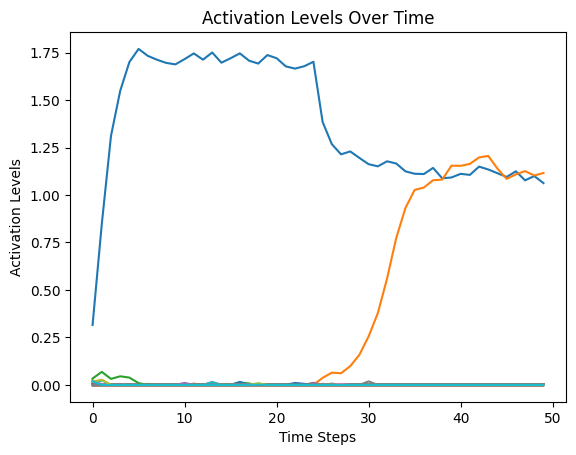

2


0.9857142857142858

In [110]:
network = ActivationNetwork(N=70, T=50, dt = 1, input_size=25)
network.run_simulation_with_graph(0.1, 1)
print(network.get_hamming_distance(0.1, 1))
1-(network.get_hamming_distance(0.1, 1)/70)

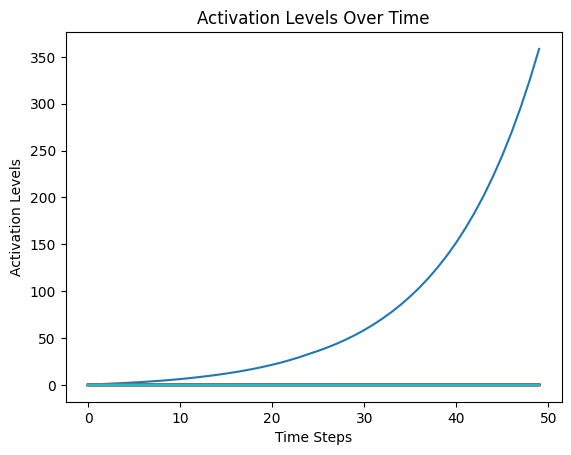

1


0.9857142857142858

In [111]:
network = ActivationNetwork(N=70, T=50, dt = 1, input_size=25)
network.run_simulation_with_graph(0.1, 1, 'linear')
print(network.get_hamming_distance(0.1, 1))
1-(network.get_hamming_distance(0.1, 1)/70)

 17%|█▋        | 1/6 [00:11<00:58, 11.71s/it]

rational sigmoid activation function: 0.58538030845084


 33%|███▎      | 2/6 [00:21<00:42, 10.53s/it]

threshold activation function: 0.5600614368071547


 50%|█████     | 3/6 [00:32<00:32, 10.82s/it]

tanh activation function: 0.5579305254010251


 67%|██████▋   | 4/6 [00:43<00:21, 10.96s/it]

sigmoid activation function: 0.5592324947545422


 83%|████████▎ | 5/6 [00:54<00:10, 10.71s/it]

linear activation function: 0.5894680128491018


100%|██████████| 6/6 [01:05<00:00, 10.95s/it]

relu activation function: 0.582329031197878


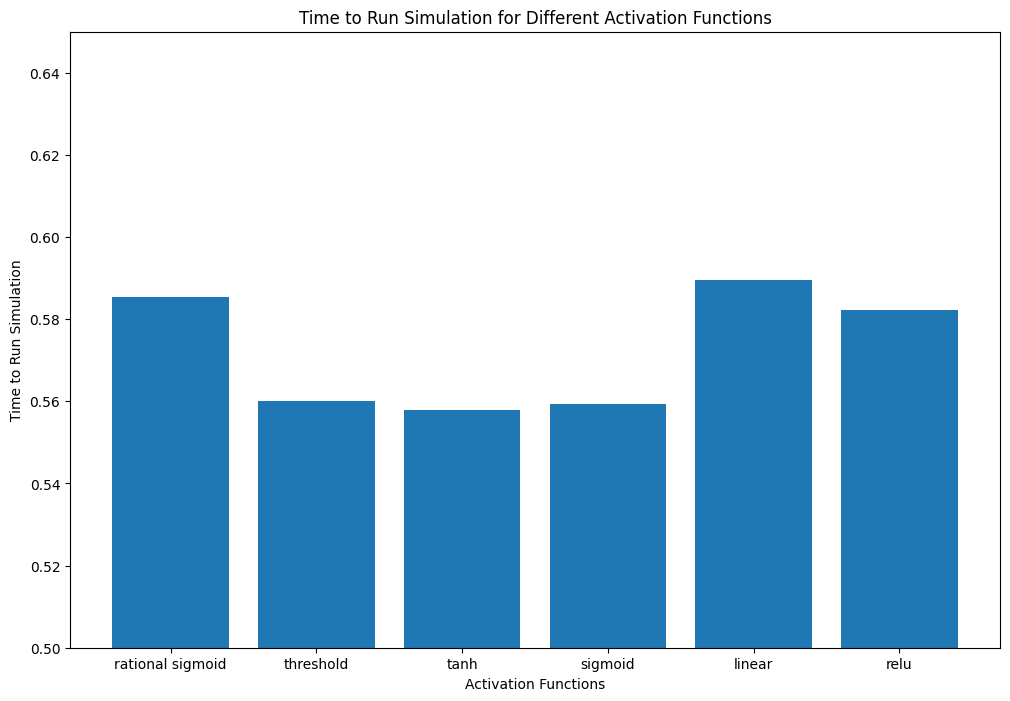

In [112]:
network.plot_hist_time_of_diff_activation_functions(0.1, 1,num_simulations=20)

In [113]:
network = ActivationNetwork(N=70, T=50, dt = 1, input_size=5)
network.run_simulation(0.1, 5)

0.05742459826511088

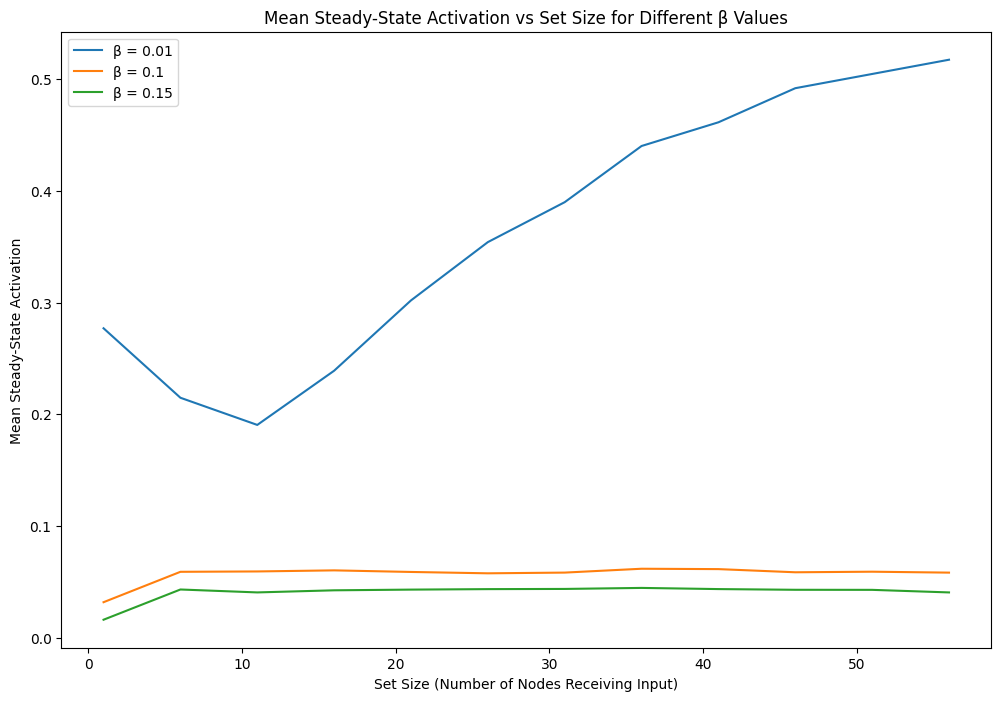

In [ ]:
betas = [0.01, 0.1, 0.15]
set_sizes = np.arange(1, 61, 5)

network = ActivationNetwork()
network.plot_mean_activation(betas, set_sizes, num_simulations=1)

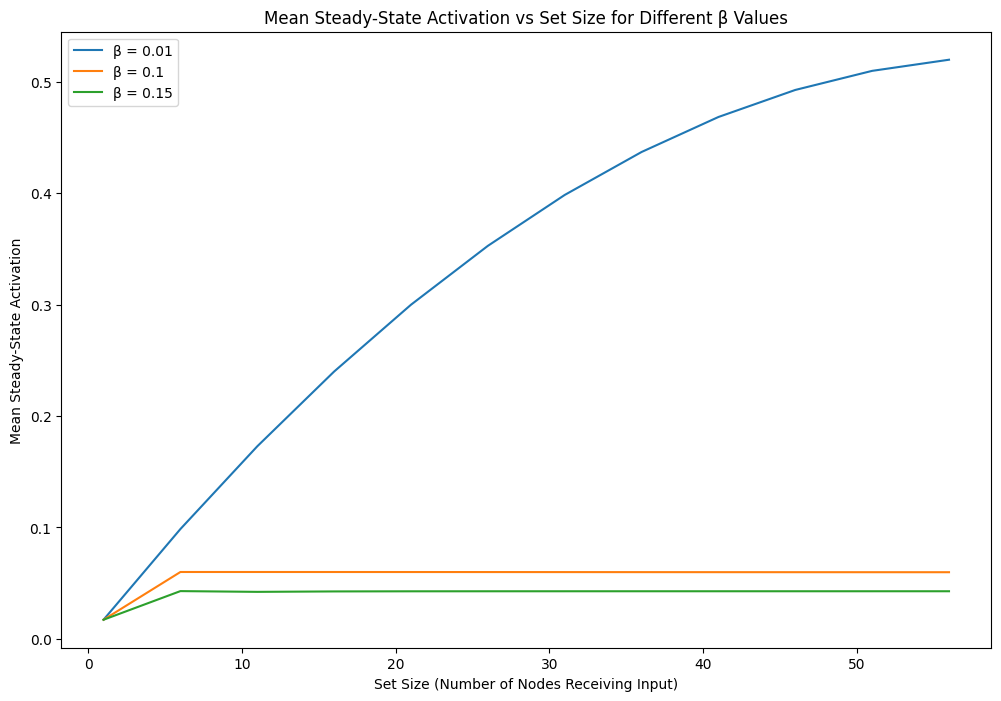

In [56]:
betas = [0.01, 0.1, 0.15]
set_sizes = np.arange(1, 61, 5)

network = ActivationNetwork(noise_std=0)
network.plot_mean_activation(betas, set_sizes, num_simulations=1)

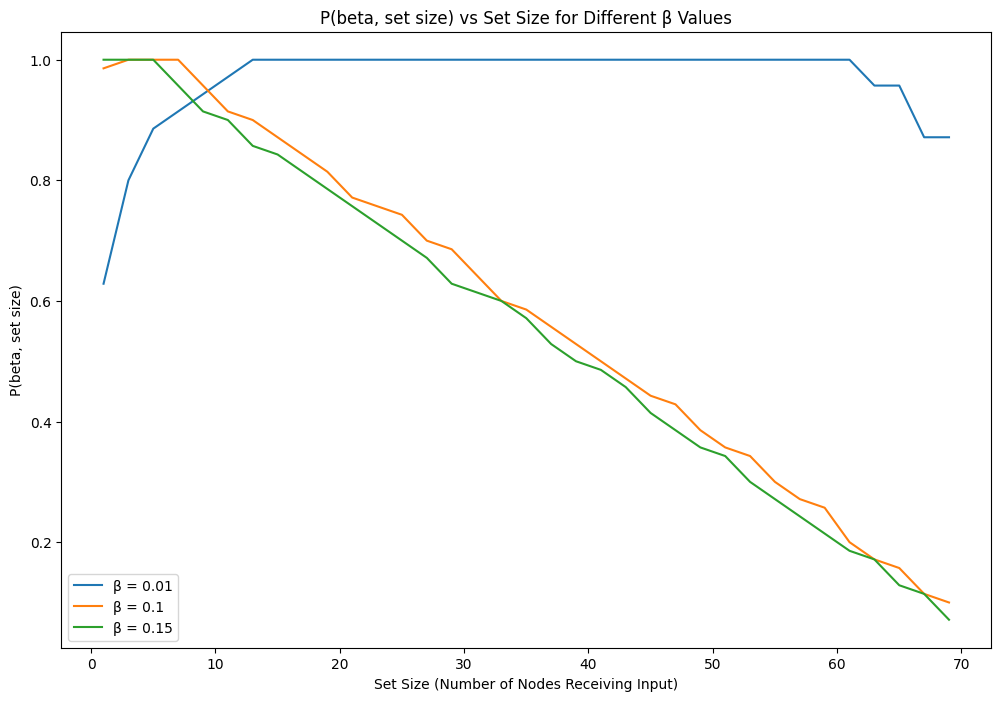

In [98]:
betas = [0.01, 0.1, 0.15]
set_sizes = np.arange(1, 71, 2)
network = ActivationNetwork()
network.plot_mean_p(betas, set_sizes, num_simulations=1)

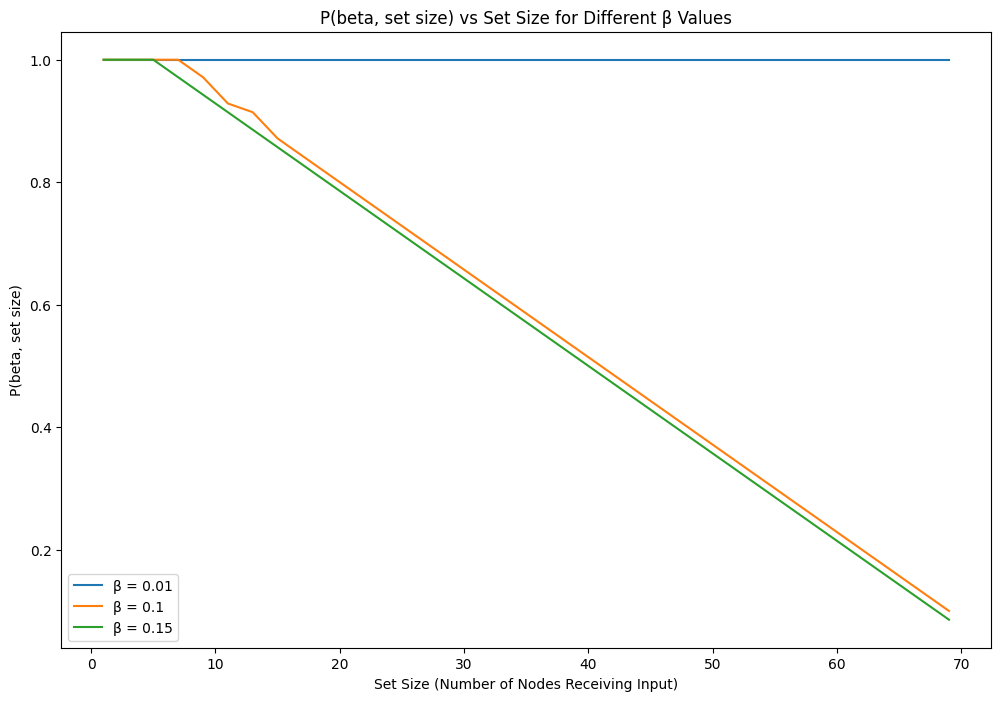

In [99]:
betas = [0.01, 0.1, 0.15]
set_sizes = np.arange(1, 71, 2)
network = ActivationNetwork(noise_std=0)
network.plot_mean_p(betas, set_sizes, num_simulations=1)

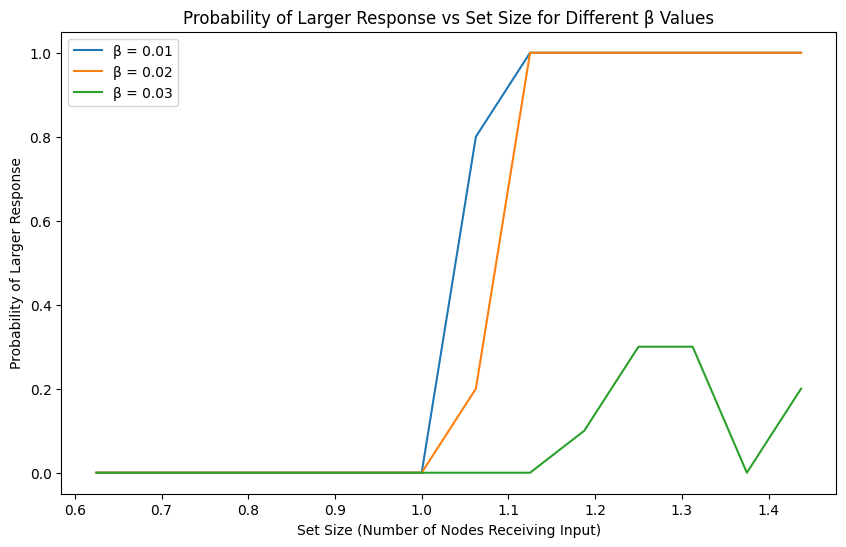

In [ ]:
specific_betas = [0.01, 0.02, 0.03]
set_sizes = np.arange(10, 24)
network = ActivationNetwork()
network.plot_probability_larger_response(specific_betas, set_sizes, num_simulations=1)

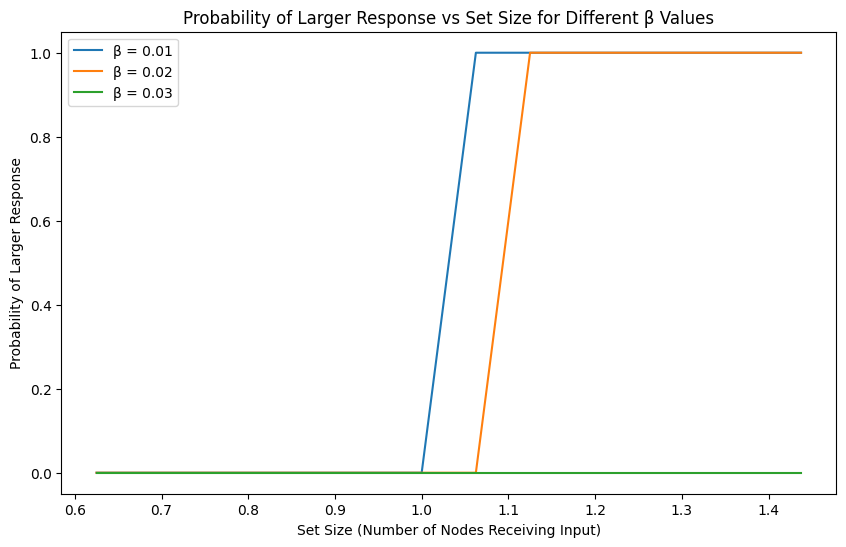

In [20]:
specific_betas = [0.01, 0.02, 0.03]
set_sizes = np.arange(10, 24)
network = ActivationNetwork(noise_std=0)
network.plot_probability_larger_response(specific_betas, set_sizes, num_simulations=1)

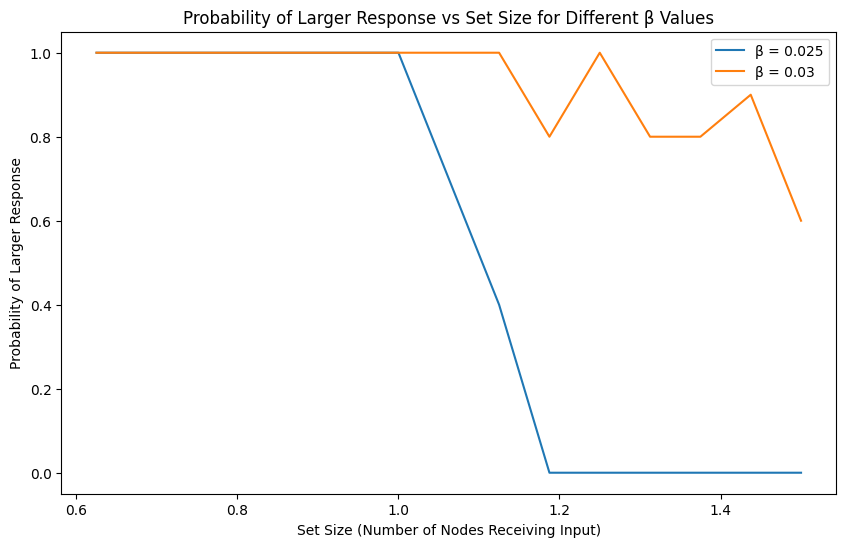

In [ ]:
specific_betas = [0.025, 0.03]
set_sizes = np.arange(10, 25)
network = ActivationNetwork()
network.plot_probability_smaller_response(specific_betas, set_sizes, num_simulations=1)

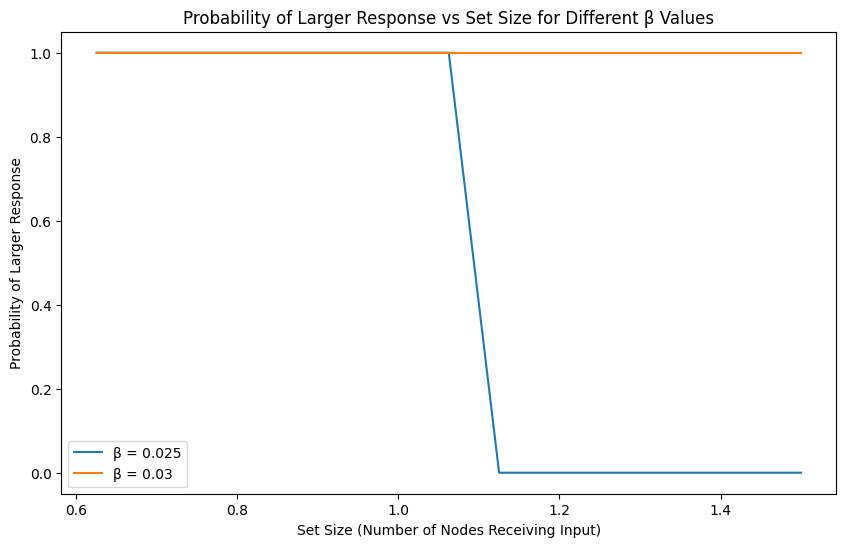

In [21]:
specific_betas = [0.025, 0.03]
set_sizes = np.arange(10, 25)
network = ActivationNetwork(noise_std=0)
network.plot_probability_smaller_response(specific_betas, set_sizes, num_simulations=1)

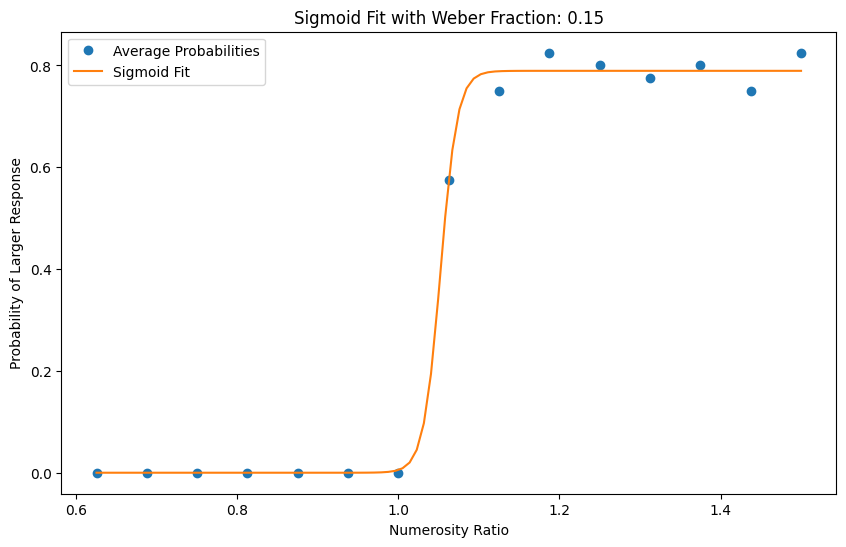

Calculated Weber Fraction: 0.14730400242910724


In [ ]:
network = ActivationNetwork()
betas = [0.01, 0.011, 0.012, 0.03]
target_numerosities = np.arange(10, 25)
const_numerosity = 16
avg_probabilities = network.average_probability_over_betas(betas, target_numerosities, const_numerosity, num_simulations=1)
numerosity_ratios = target_numerosities / const_numerosity
weber_fraction = network.fit_sigmoid_and_calculate_weber_fraction(numerosity_ratios, avg_probabilities)
print(f"Calculated Weber Fraction: {weber_fraction}")

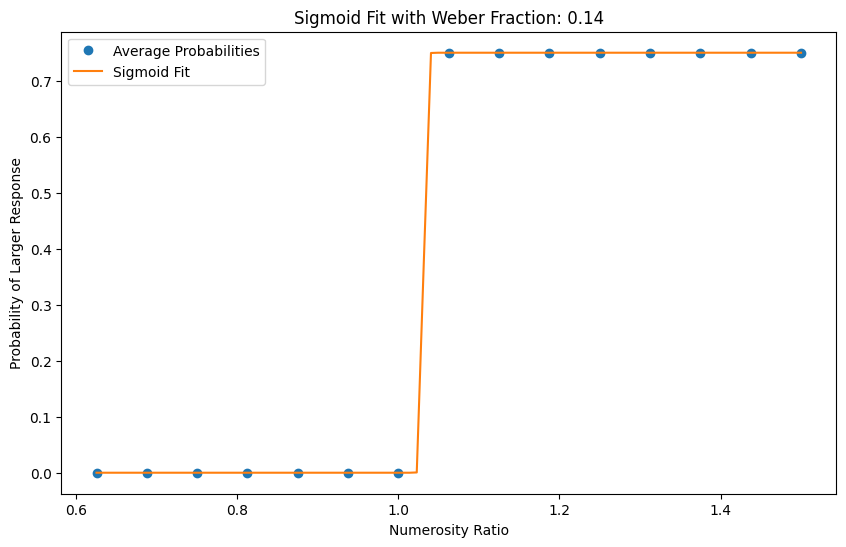

Calculated Weber Fraction: 0.14441528965064387


In [22]:
network = ActivationNetwork(noise_std=0)
betas = [0.01, 0.011, 0.012, 0.03]
target_numerosities = np.arange(10, 25)
const_numerosity = 16
avg_probabilities = network.average_probability_over_betas(betas, target_numerosities, const_numerosity, num_simulations=1)
numerosity_ratios = target_numerosities / const_numerosity
weber_fraction = network.fit_sigmoid_and_calculate_weber_fraction(numerosity_ratios, avg_probabilities)
print(f"Calculated Weber Fraction: {weber_fraction}")

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [02:25<00:00, 29.05s/it]


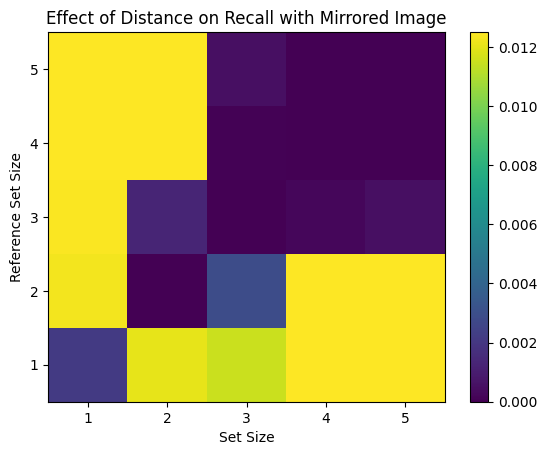

In [ ]:
network = ActivationNetwork()
betas = [0.06, 0.08, 0.1, 0.14, 0.15]
numerosities = np.arange(1, 6)
prob_matrix = network.pairwise_discrimination_probability(betas, numerosities, num_simulations=1)
network.plot_discrimination_matrix(prob_matrix, numerosities)

In [7]:
prob_matrix

array([[2.12480e-03, 1.20384e-02, 1.15136e-02, 1.24832e-02, 1.24960e-02],
       [1.22528e-02, 9.60000e-06, 2.88640e-03, 1.24960e-02, 1.24960e-02],
       [1.24384e-02, 1.28640e-03, 0.00000e+00, 2.20800e-04, 4.96000e-04],
       [1.24768e-02, 1.24960e-02, 6.40000e-05, 0.00000e+00, 1.28000e-05],
       [1.24928e-02, 1.24960e-02, 4.96000e-04, 1.60000e-05, 0.00000e+00]])

100%|██████████| 5/5 [00:45<00:00,  9.06s/it]


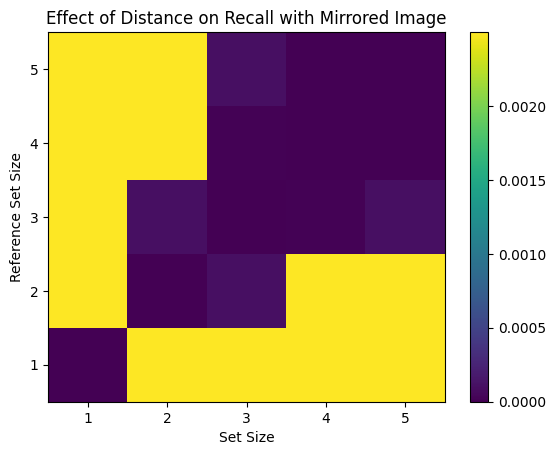

In [23]:
network = ActivationNetwork(noise_std=0)
betas = [0.06, 0.08, 0.1, 0.14, 0.15]
numerosities = np.arange(1, 6)
prob_matrix = network.pairwise_discrimination_probability(betas, numerosities, num_simulations=1)
network.plot_discrimination_matrix(prob_matrix, numerosities)

In [24]:
prob_matrix

array([[0.0000e+00, 2.4992e-03, 2.4992e-03, 2.4992e-03, 2.4992e-03],
       [2.4992e-03, 0.0000e+00, 9.9200e-05, 2.4992e-03, 2.4992e-03],
       [2.4992e-03, 9.9200e-05, 0.0000e+00, 1.9200e-05, 9.9200e-05],
       [2.4992e-03, 2.4992e-03, 1.9200e-05, 0.0000e+00, 3.2000e-06],
       [2.4992e-03, 2.4992e-03, 9.9200e-05, 3.2000e-06, 0.0000e+00]])

# Threshold

In [96]:
network = ActivationNetwork(N=70, alpha=2.2, lambda_=1.0, noise_std=0.03, dt=1, T=50, input_size = 5, input_level = 1) 
set_sizes = np.arange(1, 71, 2)

100%|██████████| 6/6 [01:10<00:00, 11.70s/it]


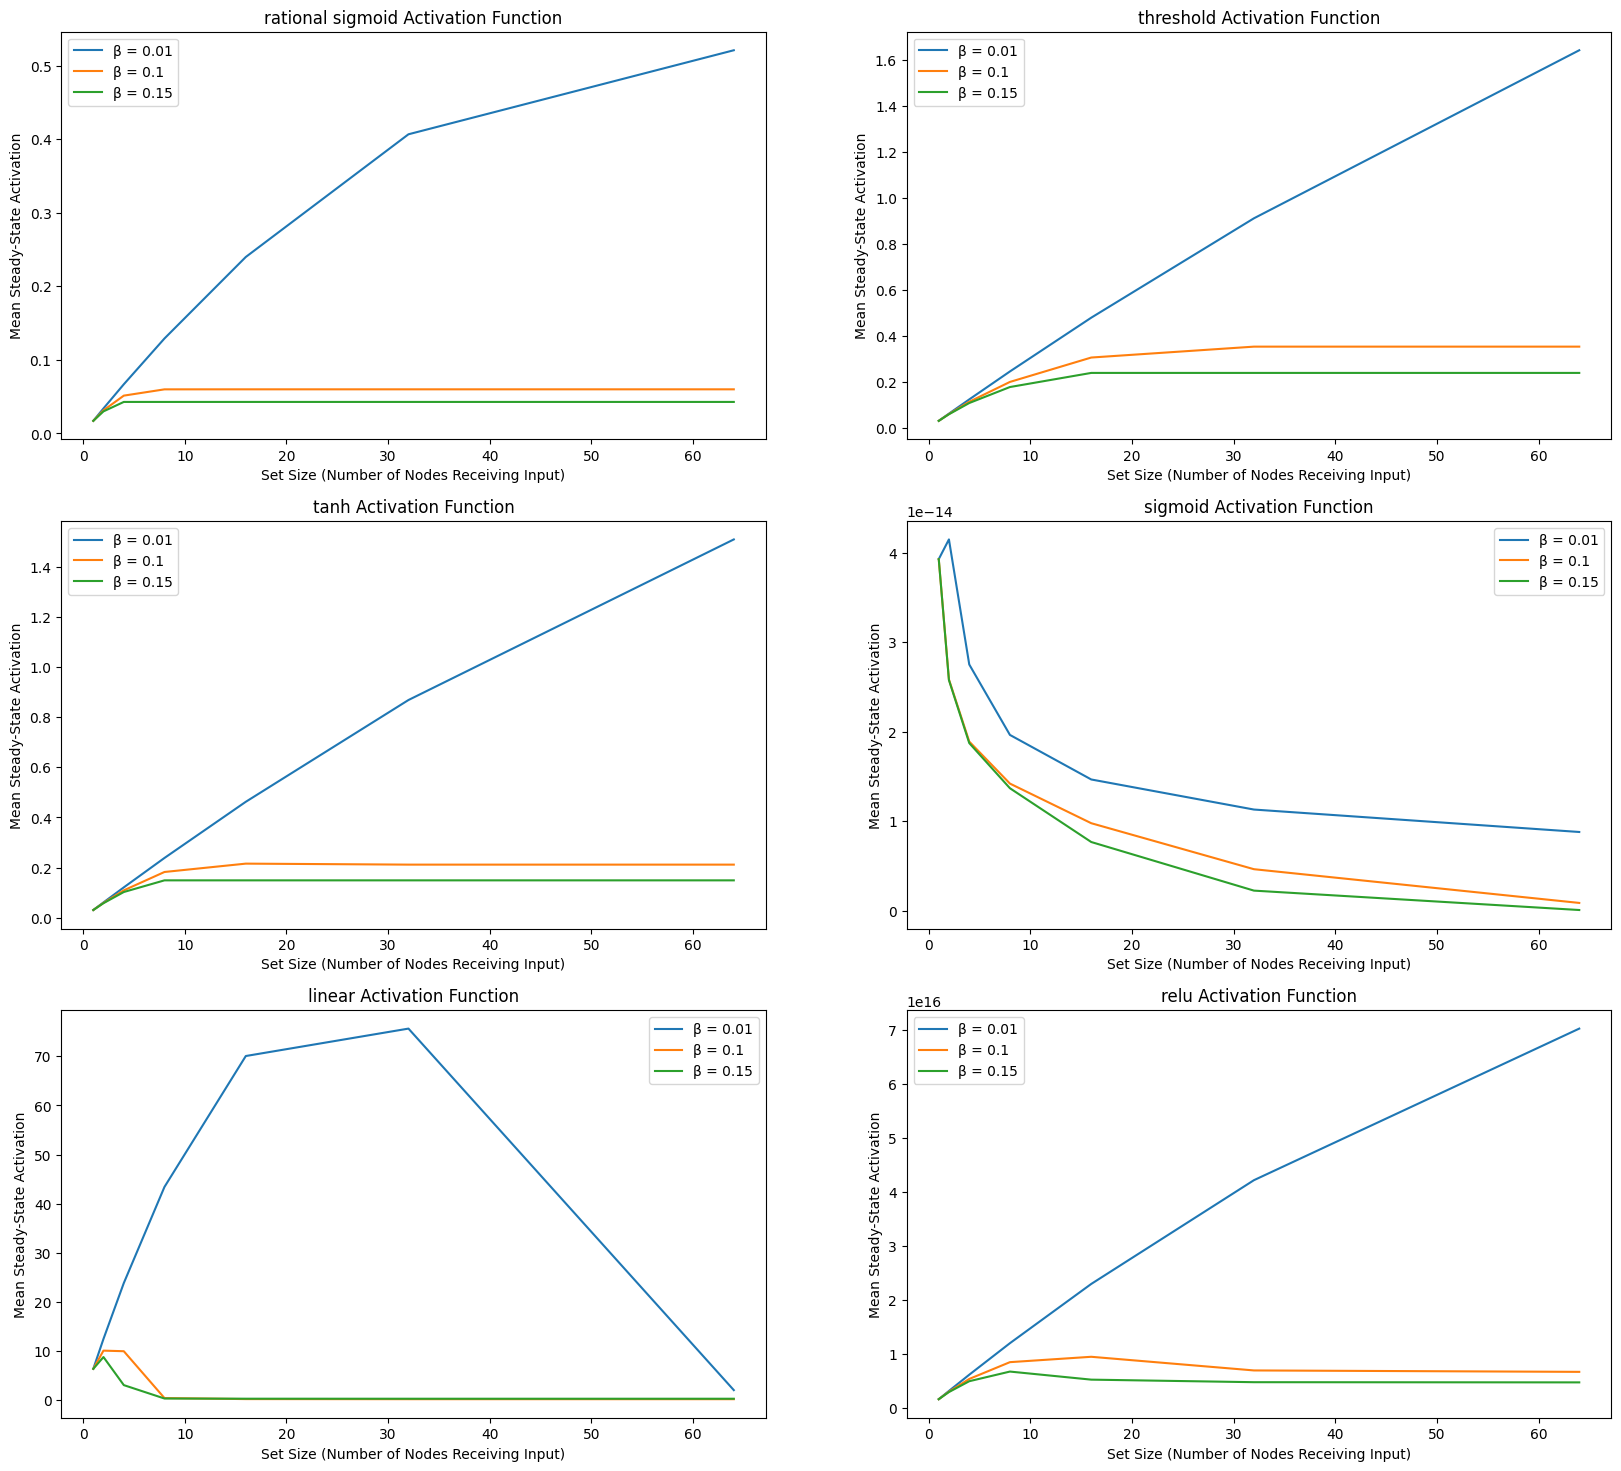

100%|██████████| 6/6 [01:11<00:00, 11.84s/it]


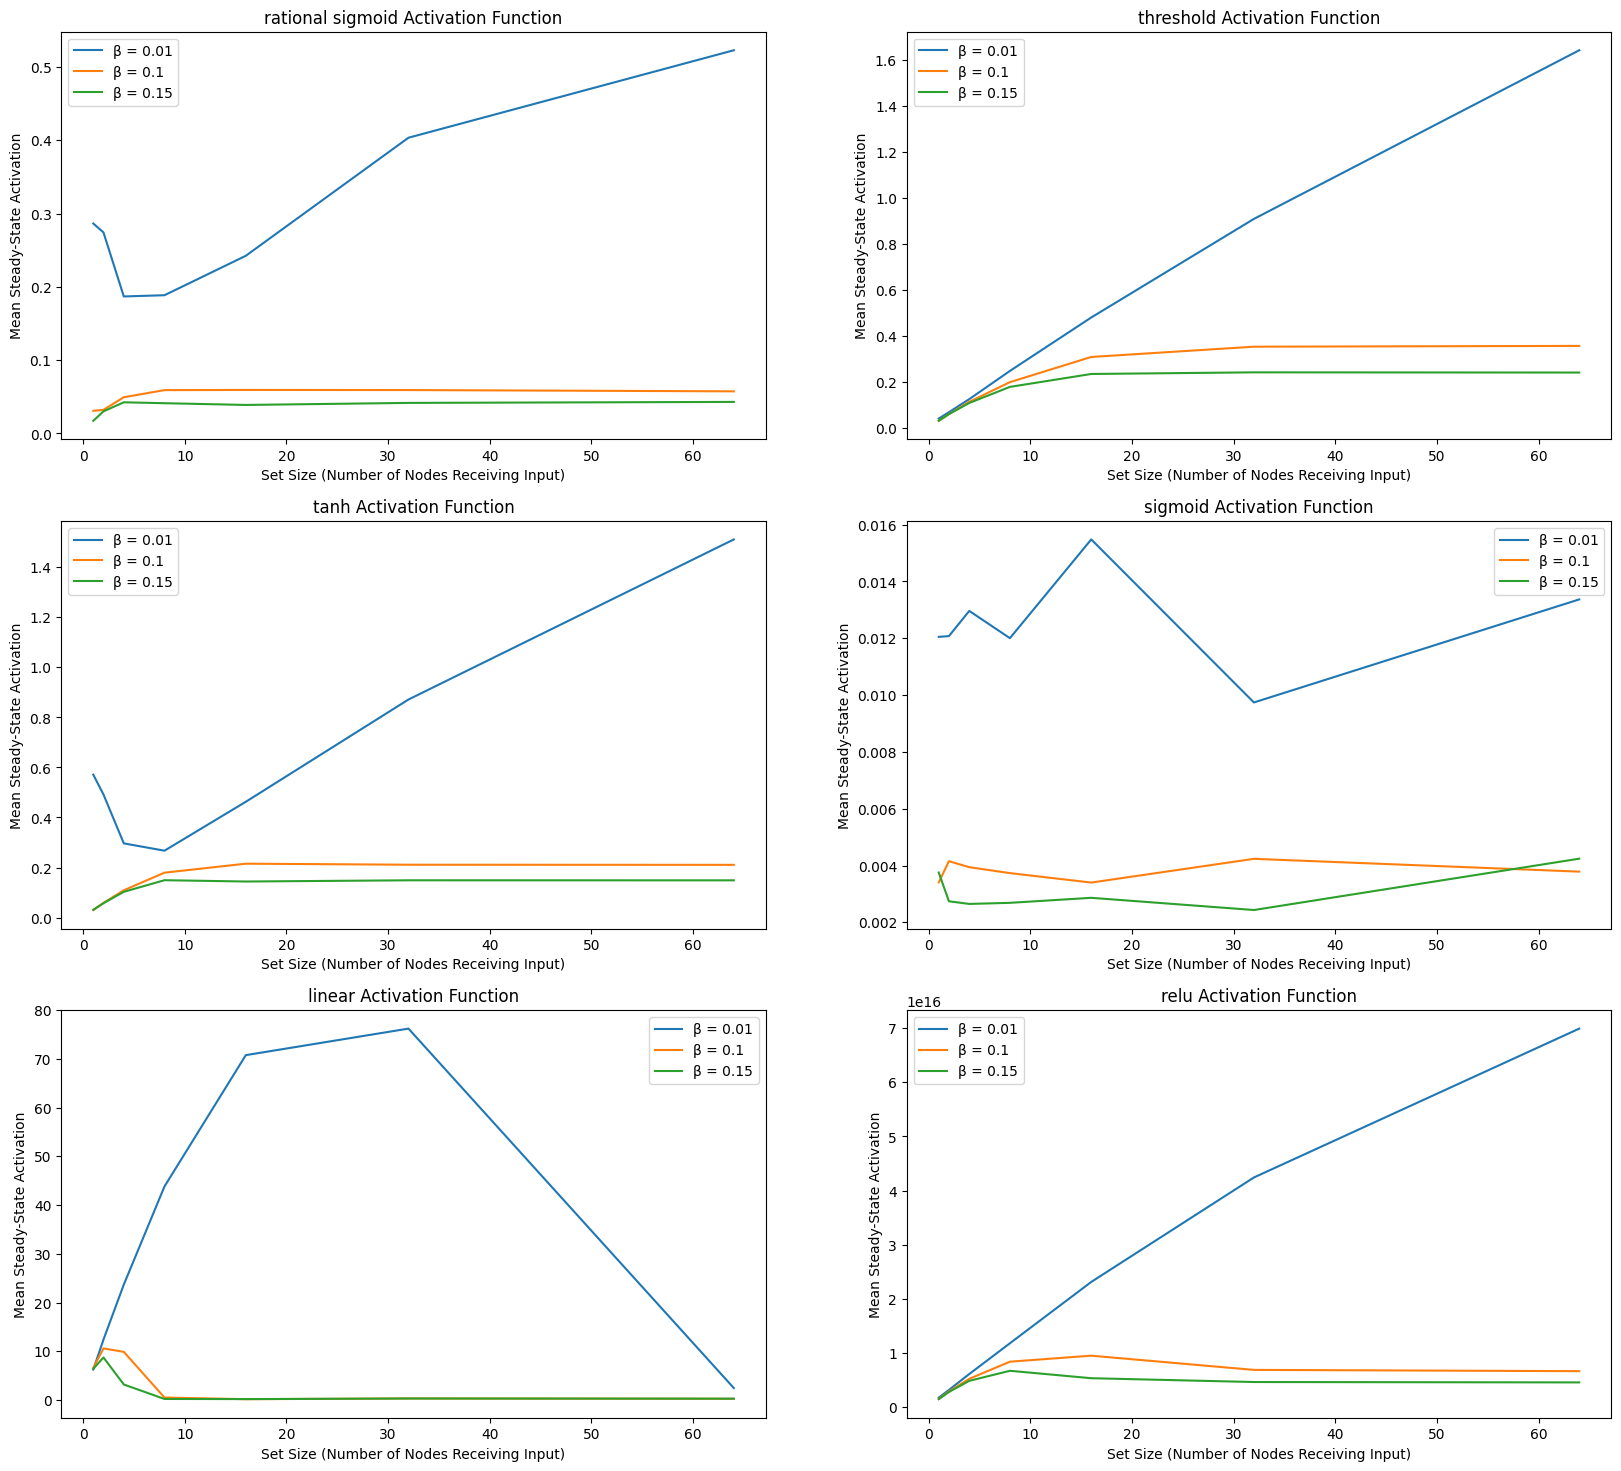

In [95]:
network.plot_mean_activations_betas_without_noise(set_sizes = [1, 2, 4, 8, 16, 32, 64], nums_simulations=1)
network.plot_mean_activations_betas_with_noise(set_sizes = [1, 2, 4, 8, 16, 32, 64], nums_simulations=1)

100%|██████████| 6/6 [05:56<00:00, 59.41s/it]


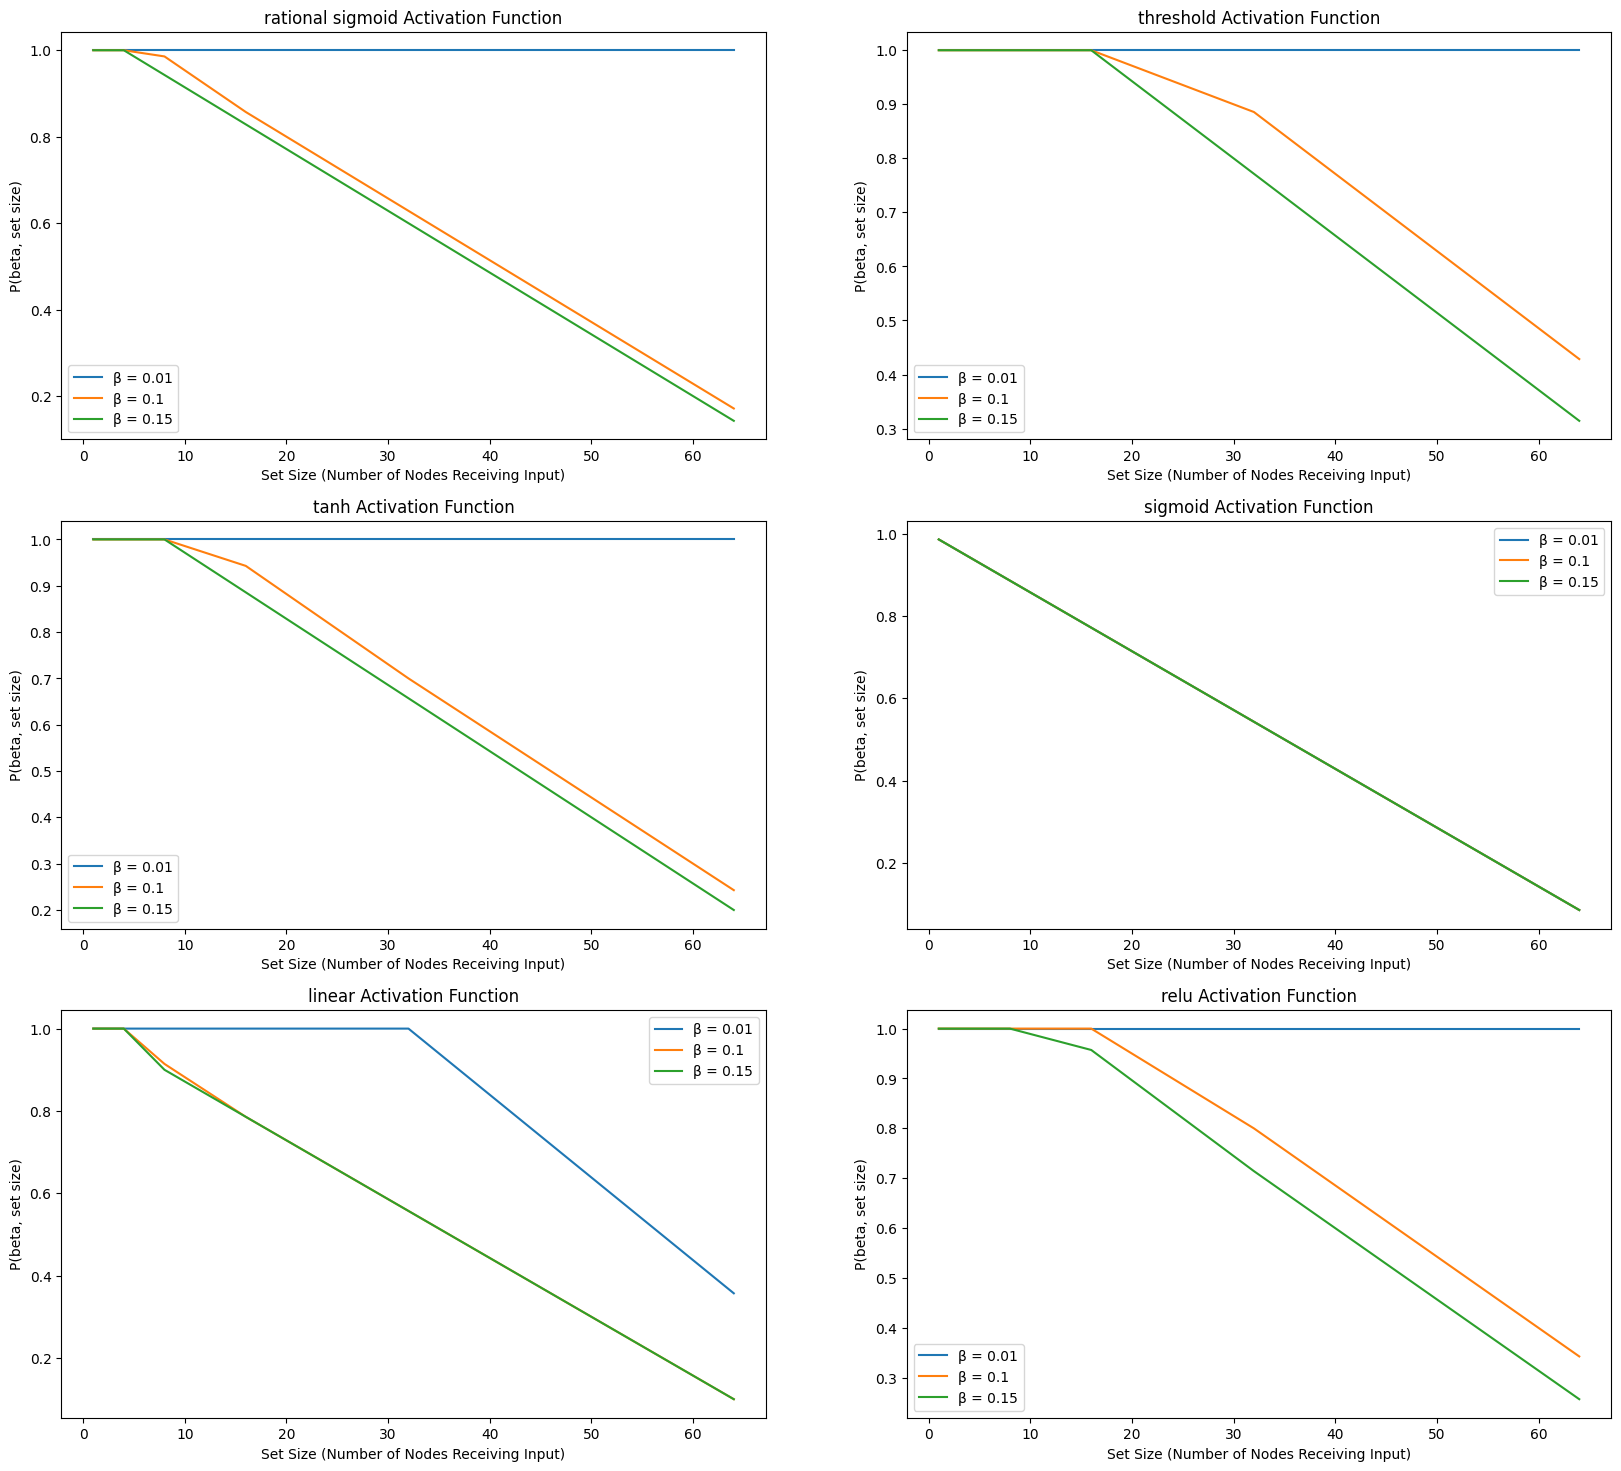

<Figure size 1200x800 with 0 Axes>

100%|██████████| 6/6 [05:56<00:00, 59.34s/it]


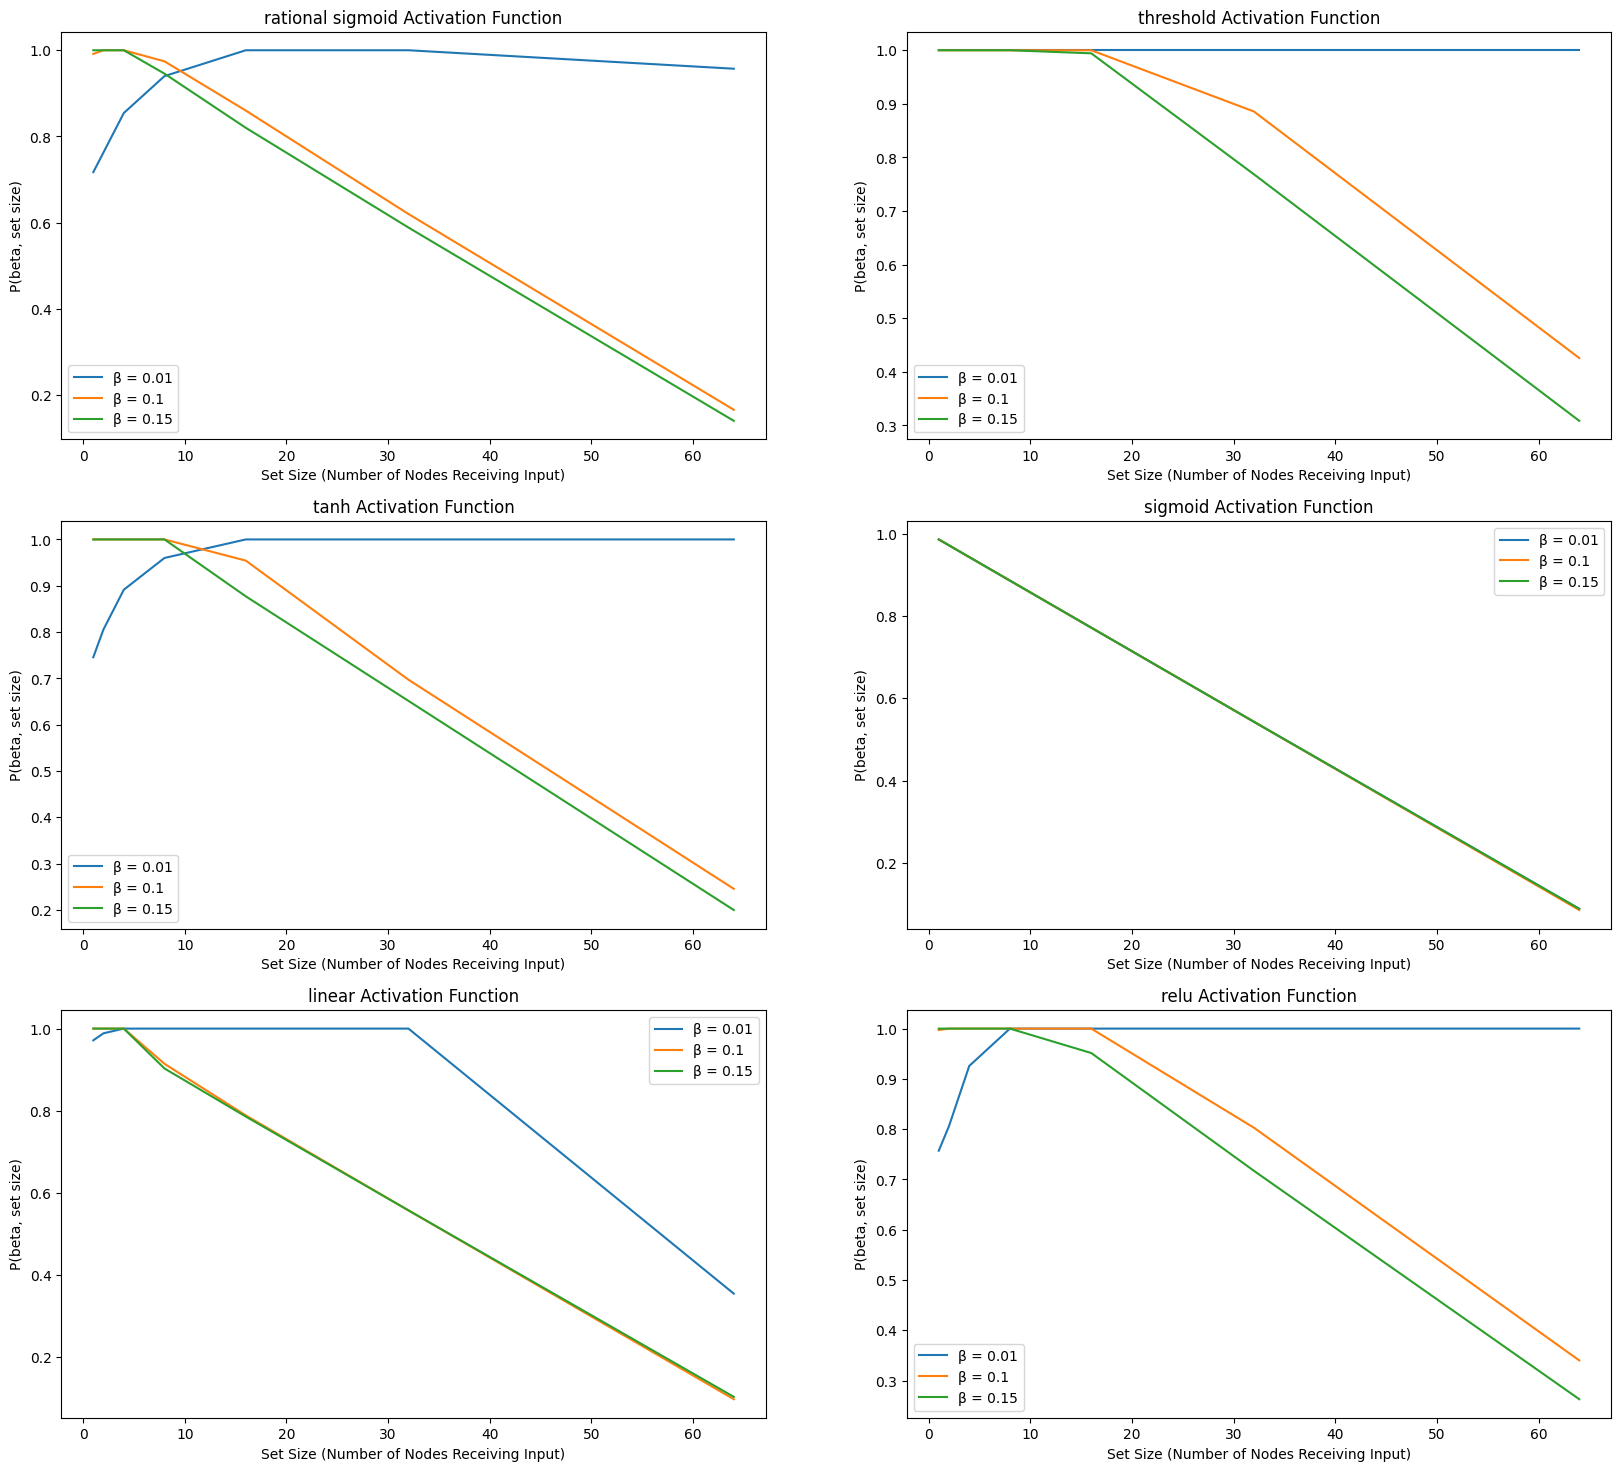

<Figure size 1200x800 with 0 Axes>

In [94]:
network.plot_mean_p_betas_without_noise(set_sizes, betas = [0.01,0.10,0.15] ,nums_simulations = 5)
network.plot_mean_p_betas_with_noise(set_sizes, betas = [0.01,0.10,0.15],noise_std = 0.03,nums_simulations = 5)

# Ablations

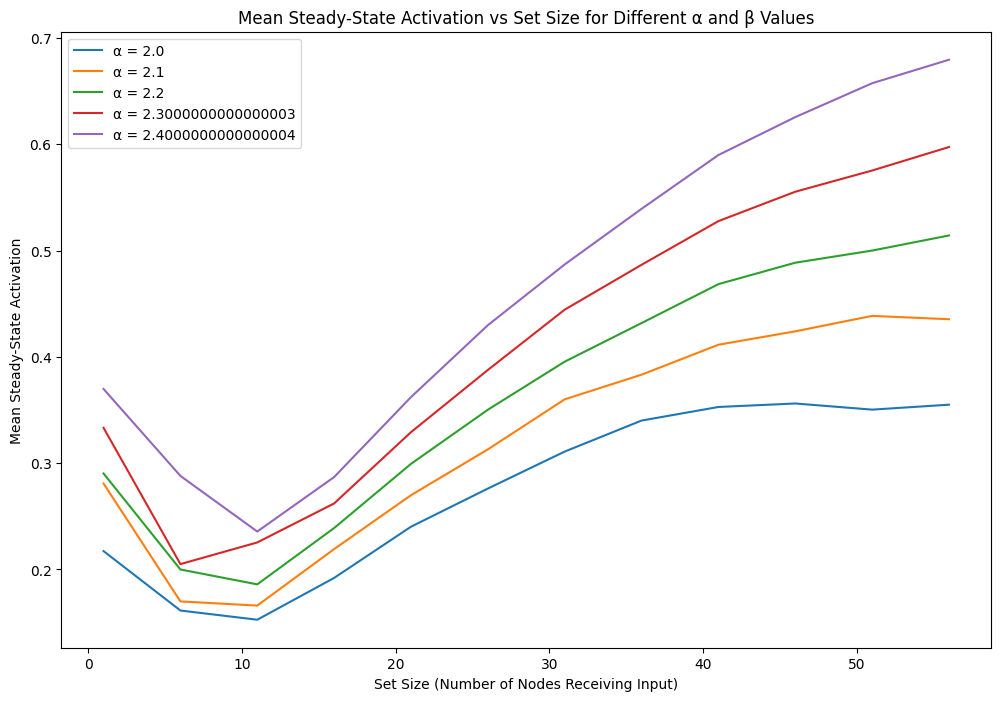

In [5]:
alphas = np.arange(2.0, 2.5, 0.1)
betas = [0.01]
set_sizes = np.arange(1, 61, 5)

plt.figure(figsize=(12, 8))

for alpha in alphas:
    network = ActivationNetwork(alpha=alpha)
    mean_activations = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_activations[i, j] = network.find_mean_activation(beta, set_size, num_simulations=1)

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_activations[i, :], label=f'α = {alpha}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Mean Steady-State Activation')
plt.title('Mean Steady-State Activation vs Set Size for Different α and β Values')
plt.legend()
plt.show()

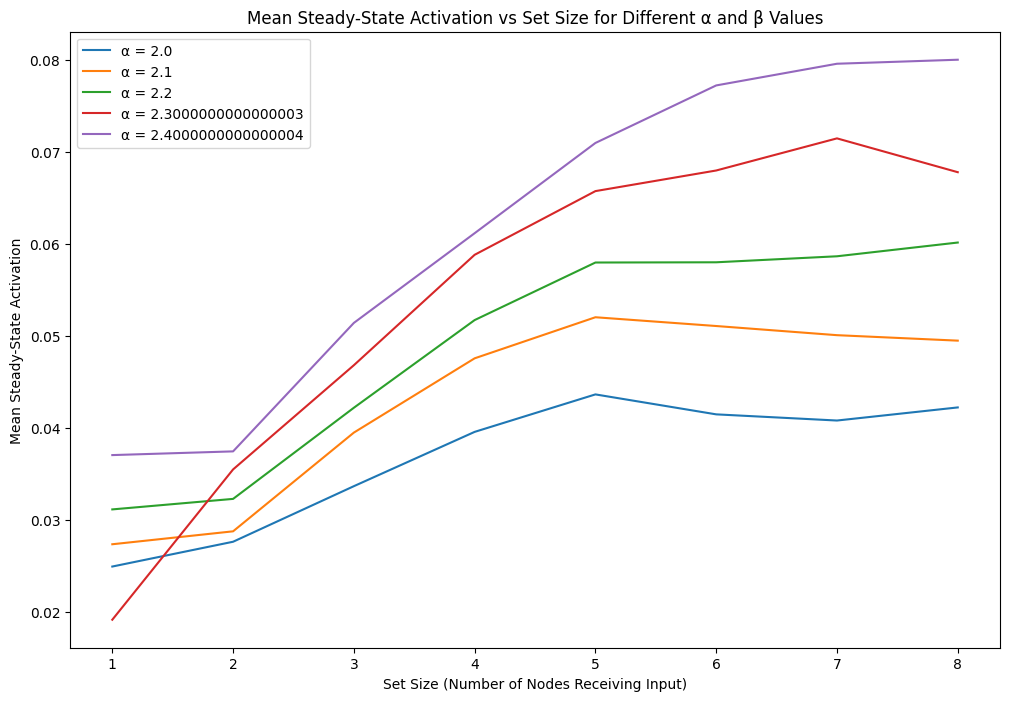

In [6]:
alphas = np.arange(2.0, 2.5, 0.1)
betas = [0.1]
set_sizes = np.arange(1, 9, 1)

plt.figure(figsize=(12, 8))

for alpha in alphas:
    network = ActivationNetwork(alpha=alpha)
    mean_activations = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_activations[i, j] = network.find_mean_activation(beta, set_size, num_simulations=1)

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_activations[i, :], label=f'α = {alpha}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Mean Steady-State Activation')
plt.title('Mean Steady-State Activation vs Set Size for Different α and β Values')
plt.legend()
plt.show()

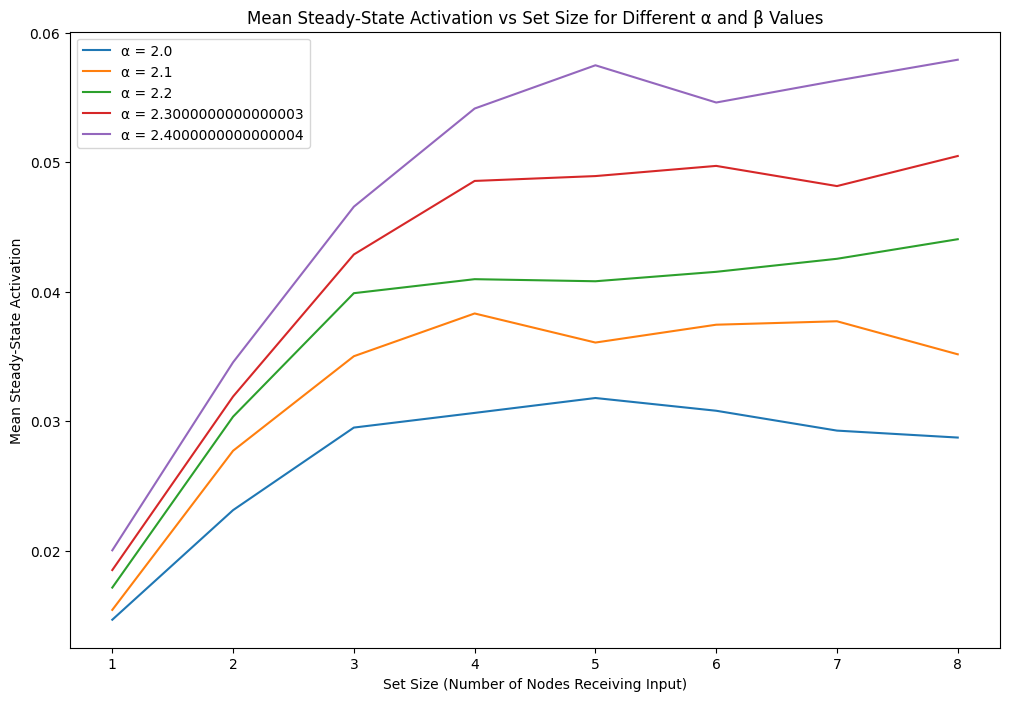

In [7]:
alphas = np.arange(2.0, 2.5, 0.1)
betas = [0.15]
set_sizes = np.arange(1, 9, 1)

plt.figure(figsize=(12, 8))

for alpha in alphas:
    network = ActivationNetwork(alpha=alpha)
    mean_activations = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_activations[i, j] = network.find_mean_activation(beta, set_size, num_simulations=1)

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_activations[i, :], label=f'α = {alpha}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Mean Steady-State Activation')
plt.title('Mean Steady-State Activation vs Set Size for Different α and β Values')
plt.legend()
plt.show()

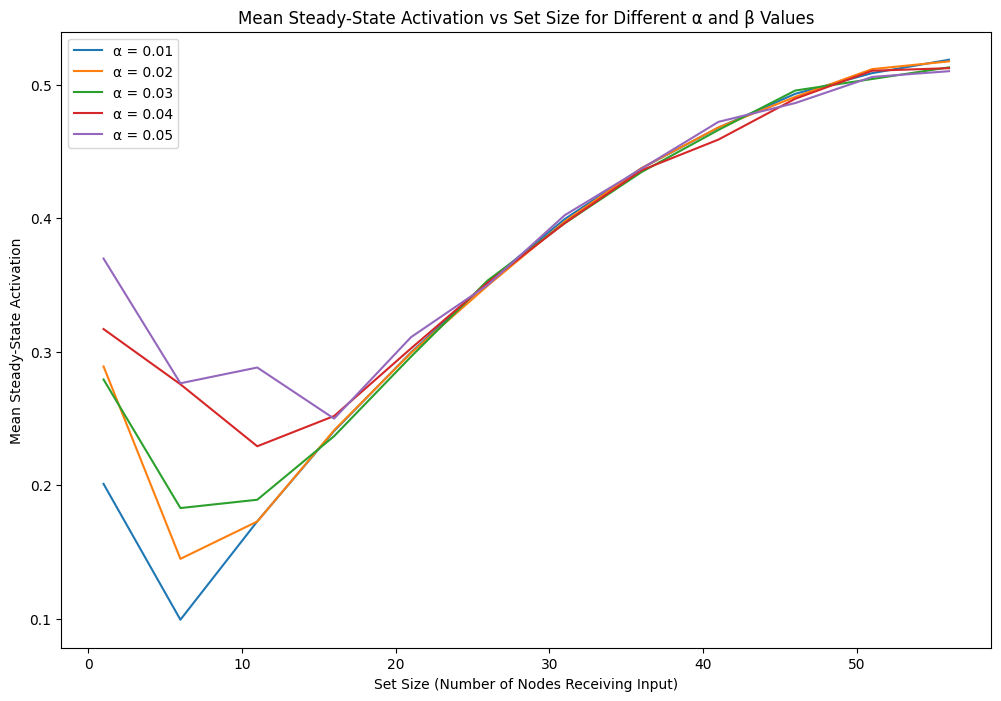

In [8]:
noises = np.arange(0.01, 0.06, 0.01)
betas = [0.01]
set_sizes = np.arange(1, 61, 5)

plt.figure(figsize=(12, 8))

for noise in noises:
    network = ActivationNetwork(noise_std=noise)
    mean_activations = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_activations[i, j] = network.find_mean_activation(beta, set_size, num_simulations=1)

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_activations[i, :], label=f'α = {noise}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Mean Steady-State Activation')
plt.title('Mean Steady-State Activation vs Set Size for Different α and β Values')
plt.legend()
plt.show()

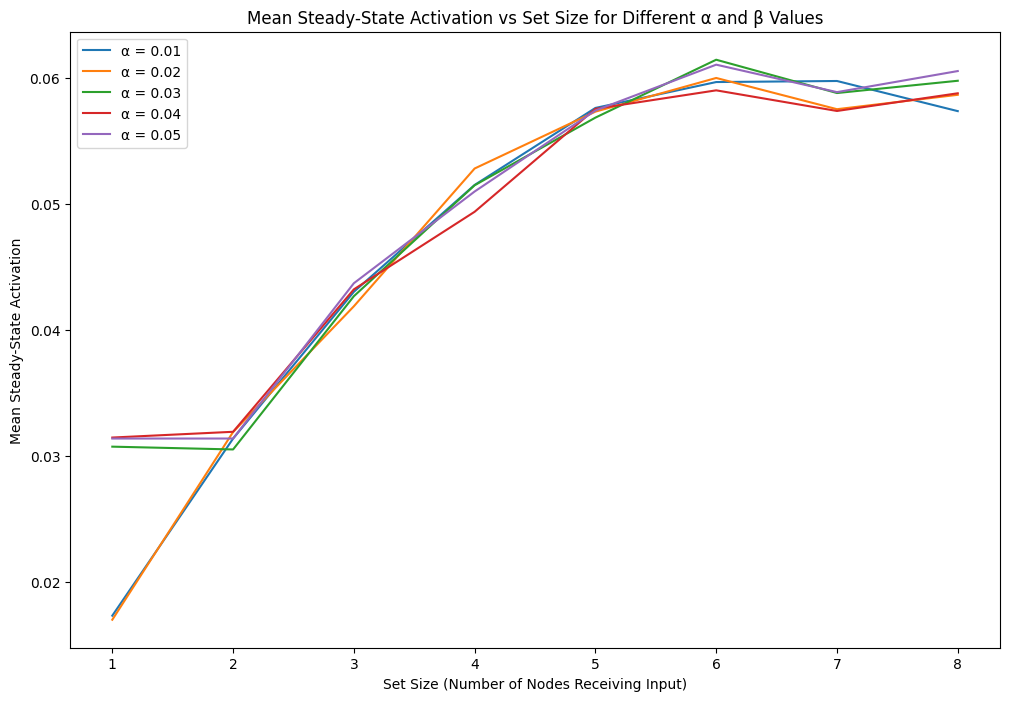

In [9]:
noises = np.arange(0.01, 0.06, 0.01)
betas = [0.1]
set_sizes = np.arange(1, 9, 1)

plt.figure(figsize=(12, 8))

for noise in noises:
    network = ActivationNetwork(noise_std=noise)
    mean_activations = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_activations[i, j] = network.find_mean_activation(beta, set_size, num_simulations=1)

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_activations[i, :], label=f'α = {noise}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Mean Steady-State Activation')
plt.title('Mean Steady-State Activation vs Set Size for Different α and β Values')
plt.legend()
plt.show()

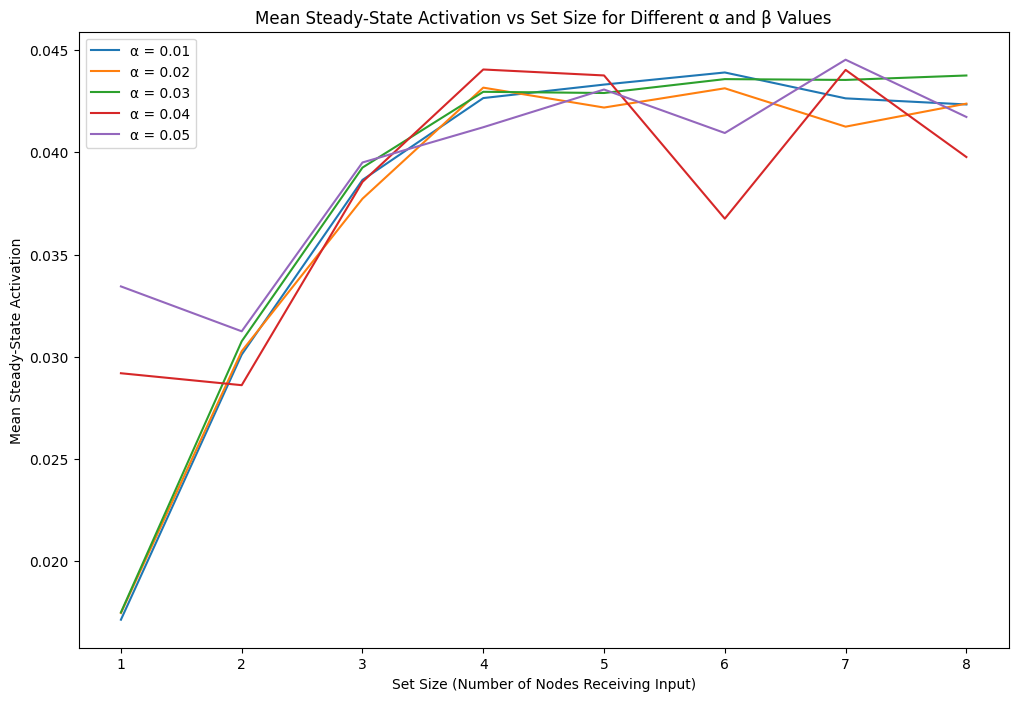

In [10]:
noises = np.arange(0.01, 0.06, 0.01)
betas = [0.15]
set_sizes = np.arange(1, 9, 1)

plt.figure(figsize=(12, 8))

for noise in noises:
    network = ActivationNetwork(noise_std=noise)
    mean_activations = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_activations[i, j] = network.find_mean_activation(beta, set_size, num_simulations=1)

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_activations[i, :], label=f'α = {noise}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Mean Steady-State Activation')
plt.title('Mean Steady-State Activation vs Set Size for Different α and β Values')
plt.legend()
plt.show()

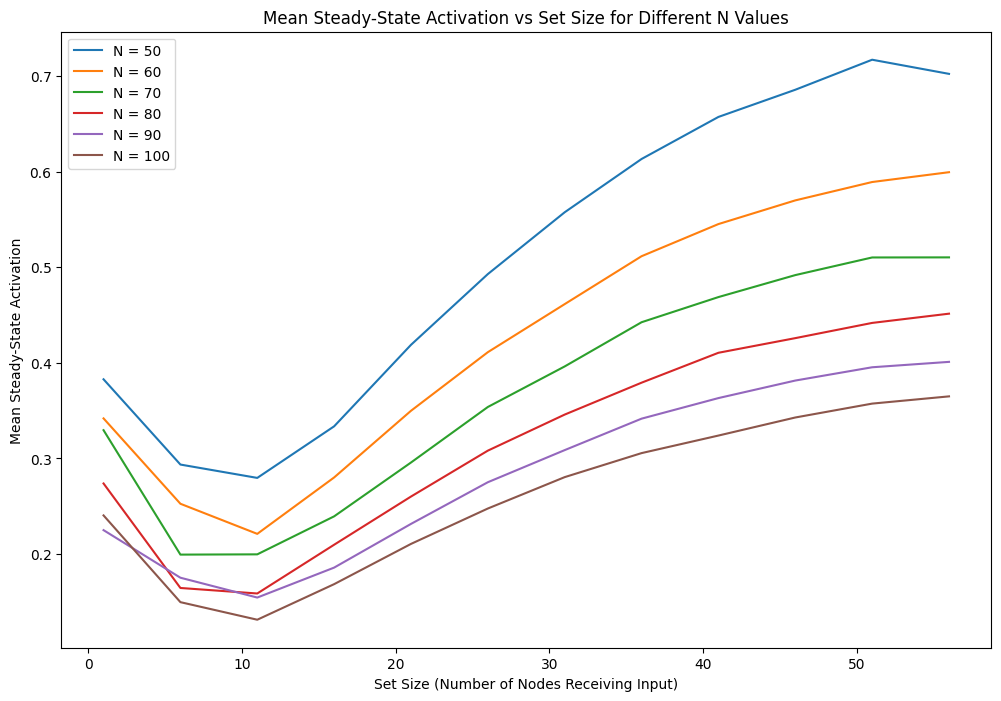

In [11]:
Ns = np.arange(50, 101, 10)
betas = [0.01]
set_sizes = np.arange(1, 61, 5)

plt.figure(figsize=(12, 8))

for N in Ns:
    network = ActivationNetwork(N=N)
    mean_activations = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_activations[i, j] = network.find_mean_activation(beta, set_size, num_simulations=1)

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_activations[i, :], label=f'N = {N}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Mean Steady-State Activation')
plt.title('Mean Steady-State Activation vs Set Size for Different N Values')
plt.legend()
plt.show()

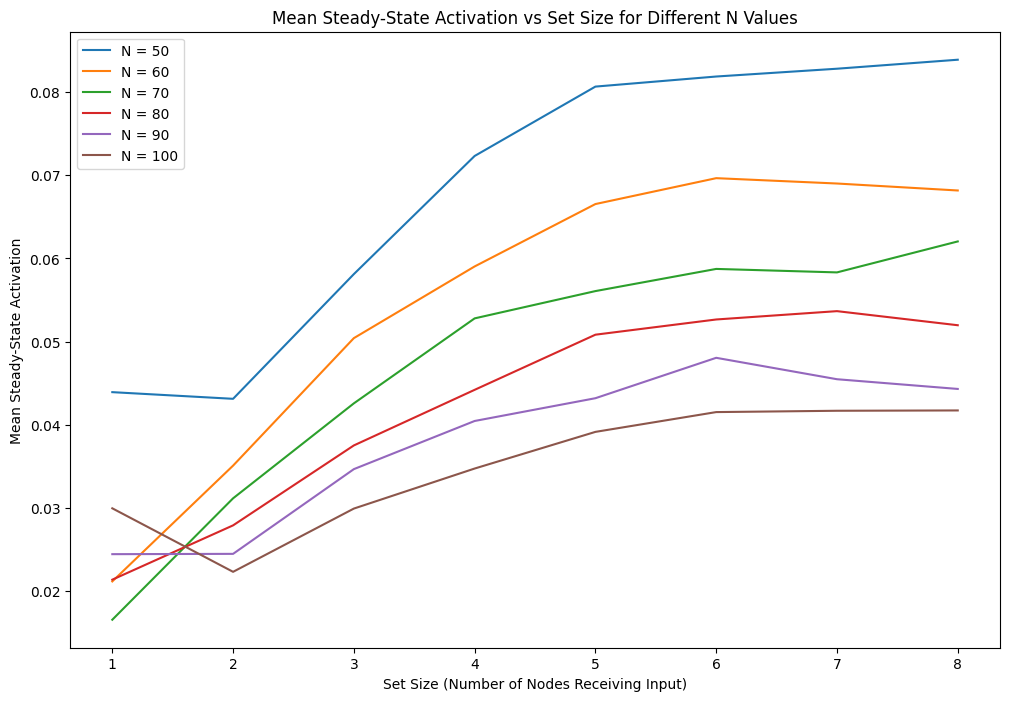

In [12]:
Ns = np.arange(50, 101, 10)
betas = [0.1]
set_sizes = np.arange(1, 9, 1)

plt.figure(figsize=(12, 8))

for N in Ns:
    network = ActivationNetwork(N=N)
    mean_activations = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_activations[i, j] = network.find_mean_activation(beta, set_size, num_simulations=1)

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_activations[i, :], label=f'N = {N}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Mean Steady-State Activation')
plt.title('Mean Steady-State Activation vs Set Size for Different N Values')
plt.legend()
plt.show()

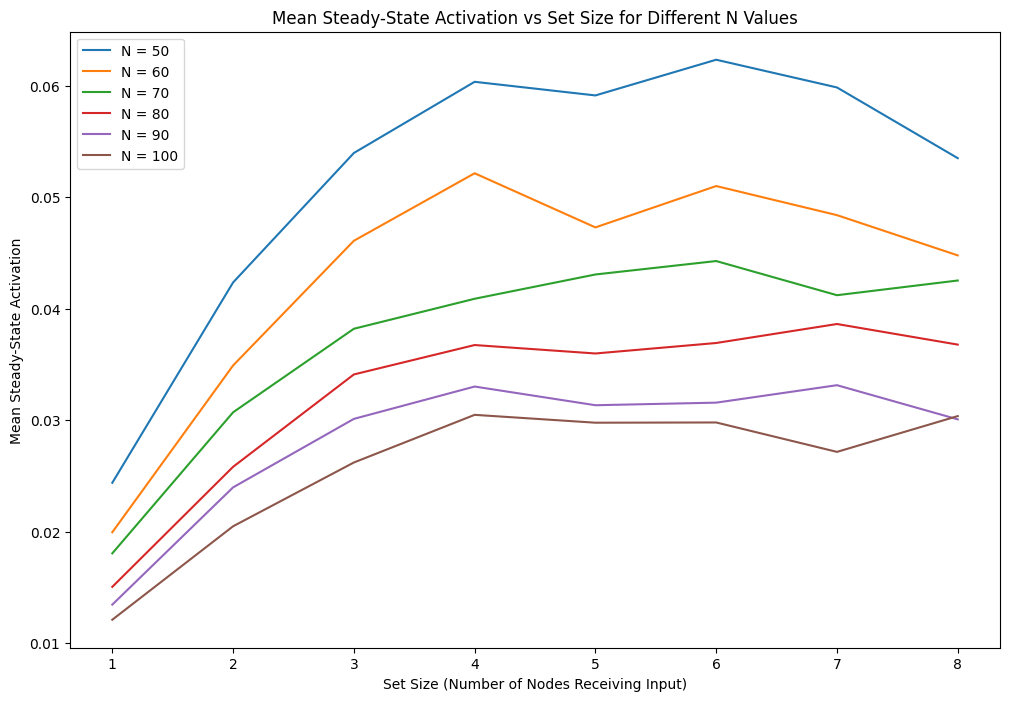

In [13]:
Ns = np.arange(50, 101, 10)
betas = [0.15]
set_sizes = np.arange(1, 9, 1)

plt.figure(figsize=(12, 8))

for N in Ns:
    network = ActivationNetwork(N=N)
    mean_activations = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_activations[i, j] = network.find_mean_activation(beta, set_size, num_simulations=1)

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_activations[i, :], label=f'N = {N}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Mean Steady-State Activation')
plt.title('Mean Steady-State Activation vs Set Size for Different N Values')
plt.legend()
plt.show()

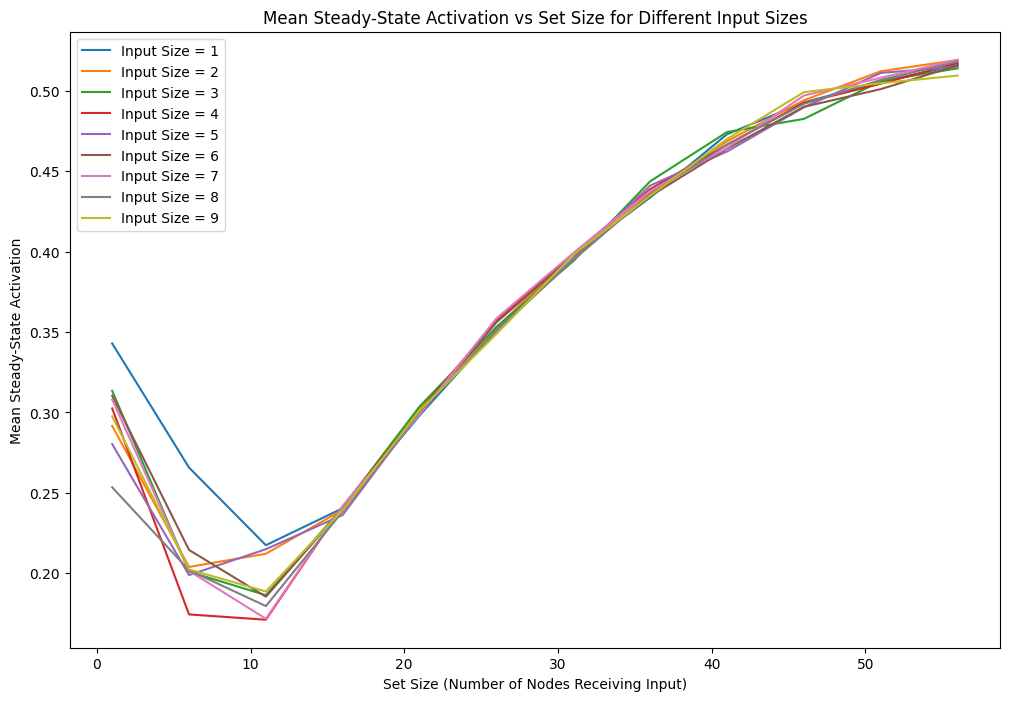

In [4]:
input_sizes = np.arange(1, 10, 1)
betas = [0.01]
set_sizes = np.arange(1, 61, 5)

plt.figure(figsize=(12, 8))

for input_size in input_sizes:
    network = ActivationNetwork(input_size=input_size)
    mean_activations = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_activations[i, j] = network.find_mean_activation(beta, set_size, num_simulations=1)

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_activations[i, :], label=f'Input Size = {input_size}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Mean Steady-State Activation')
plt.title('Mean Steady-State Activation vs Set Size for Different Input Sizes')
plt.legend()
plt.show()

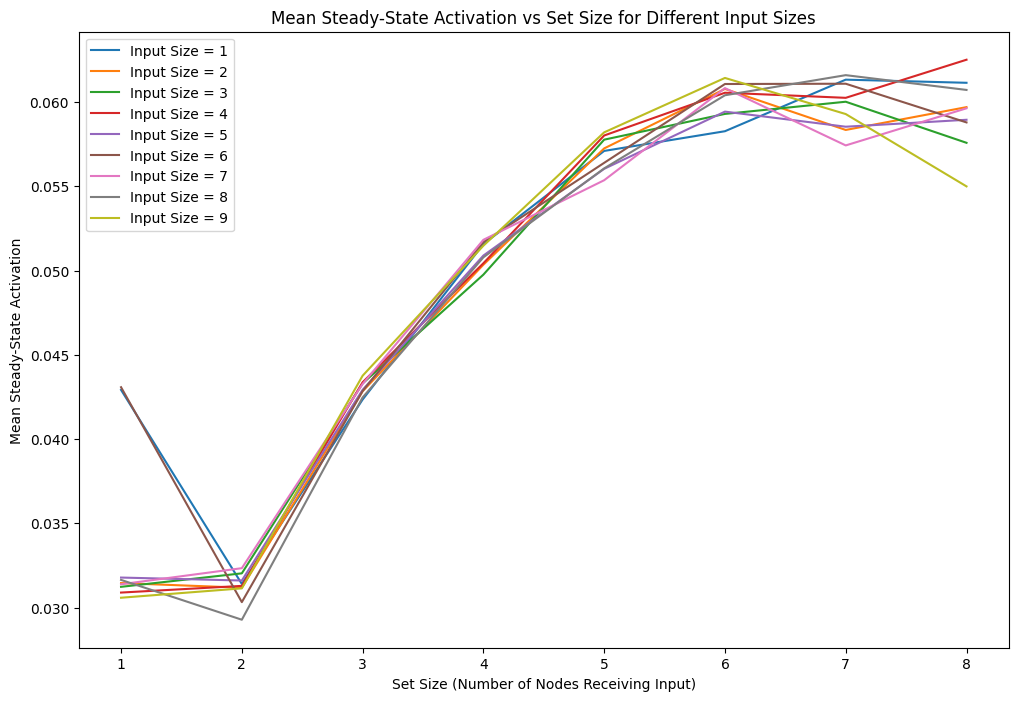

In [5]:
input_sizes = np.arange(1, 10, 1)
betas = [0.1]
set_sizes = np.arange(1, 9, 1)

plt.figure(figsize=(12, 8))

for input_size in input_sizes:
    network = ActivationNetwork(input_size=input_size)
    mean_activations = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_activations[i, j] = network.find_mean_activation(beta, set_size, num_simulations=1)

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_activations[i, :], label=f'Input Size = {input_size}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Mean Steady-State Activation')
plt.title('Mean Steady-State Activation vs Set Size for Different Input Sizes')
plt.legend()
plt.show()

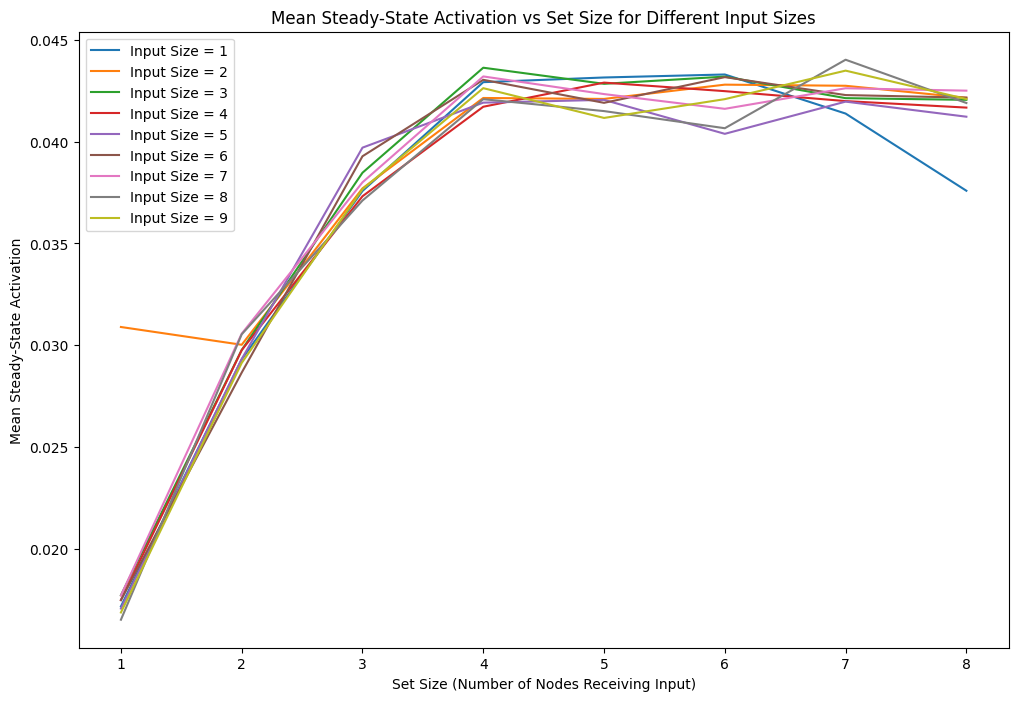

In [6]:
input_sizes = np.arange(1, 10, 1)
betas = [0.15]
set_sizes = np.arange(1, 9, 1)

plt.figure(figsize=(12, 8))

for input_size in input_sizes:
    network = ActivationNetwork(input_size=input_size)
    mean_activations = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_activations[i, j] = network.find_mean_activation(beta, set_size, num_simulations=1)

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_activations[i, :], label=f'Input Size = {input_size}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Mean Steady-State Activation')
plt.title('Mean Steady-State Activation vs Set Size for Different Input Sizes')
plt.legend()
plt.show()

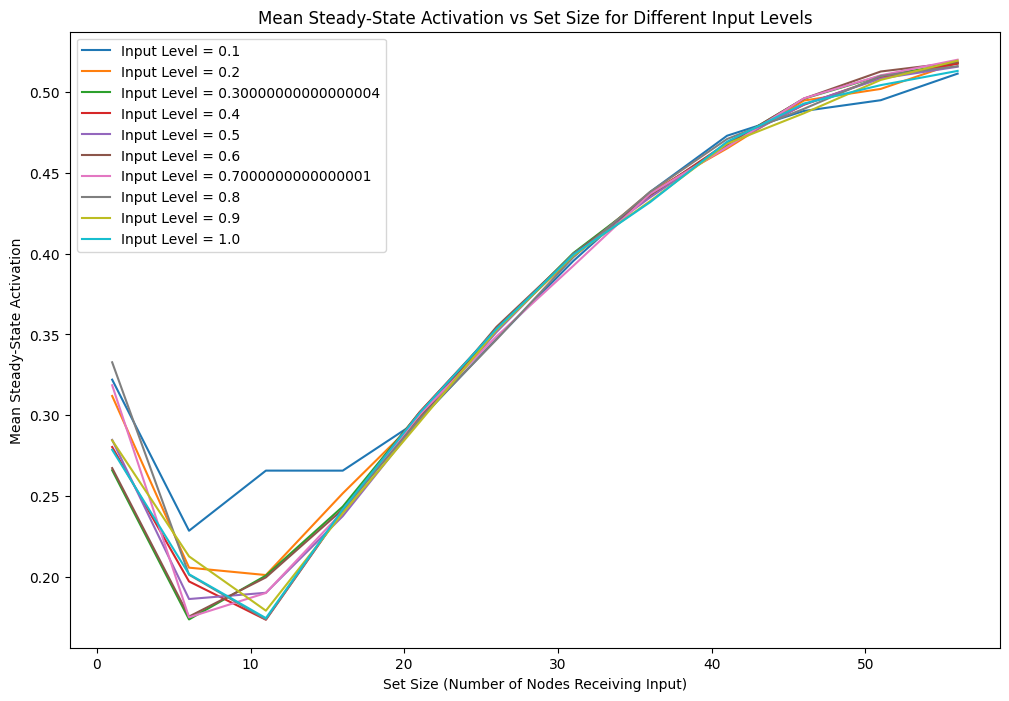

In [9]:
input_levels = np.arange(0.1, 1.1, 0.1)
betas = [0.01]
set_sizes = np.arange(1, 61, 5)

plt.figure(figsize=(12, 8))

for input_level in input_levels:
    network = ActivationNetwork(input_level=input_level)
    mean_activations = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_activations[i, j] = network.find_mean_activation(beta, set_size, num_simulations=1)

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_activations[i, :], label=f'Input Level = {input_level}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Mean Steady-State Activation')
plt.title('Mean Steady-State Activation vs Set Size for Different Input Levels')
plt.legend()
plt.show()

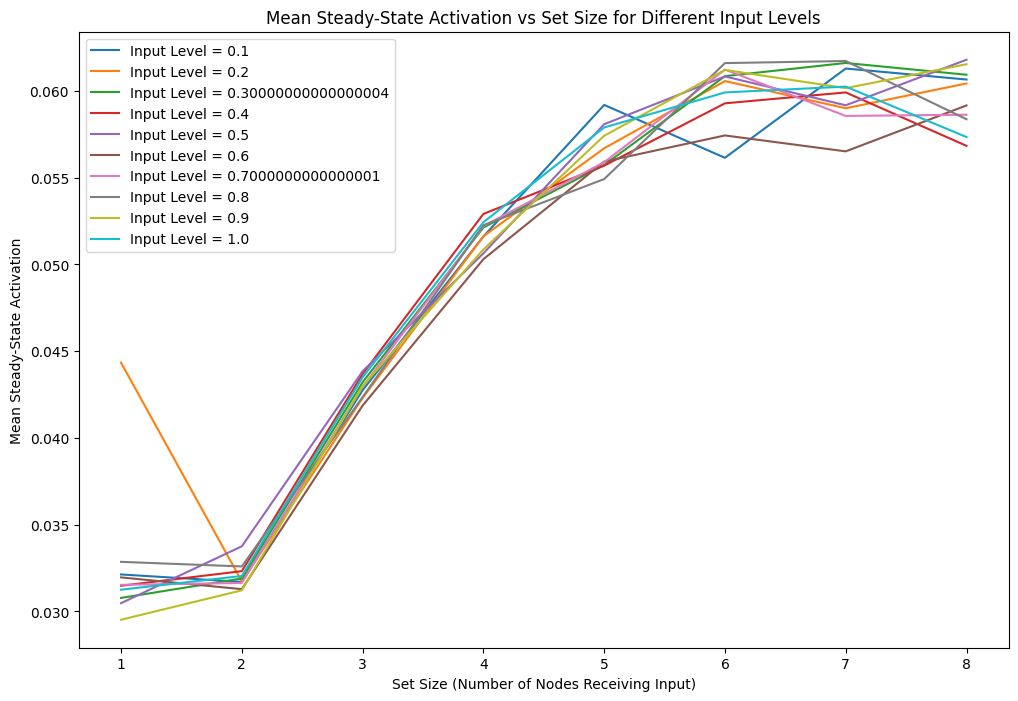

In [8]:
input_levels = np.arange(0.1, 1.1, 0.1)
betas = [0.1]
set_sizes = np.arange(1, 9, 1)

plt.figure(figsize=(12, 8))

for input_level in input_levels:
    network = ActivationNetwork(input_level=input_level)
    mean_activations = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_activations[i, j] = network.find_mean_activation(beta, set_size, num_simulations=1)

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_activations[i, :], label=f'Input Level = {input_level}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Mean Steady-State Activation')
plt.title('Mean Steady-State Activation vs Set Size for Different Input Levels')
plt.legend()
plt.show()

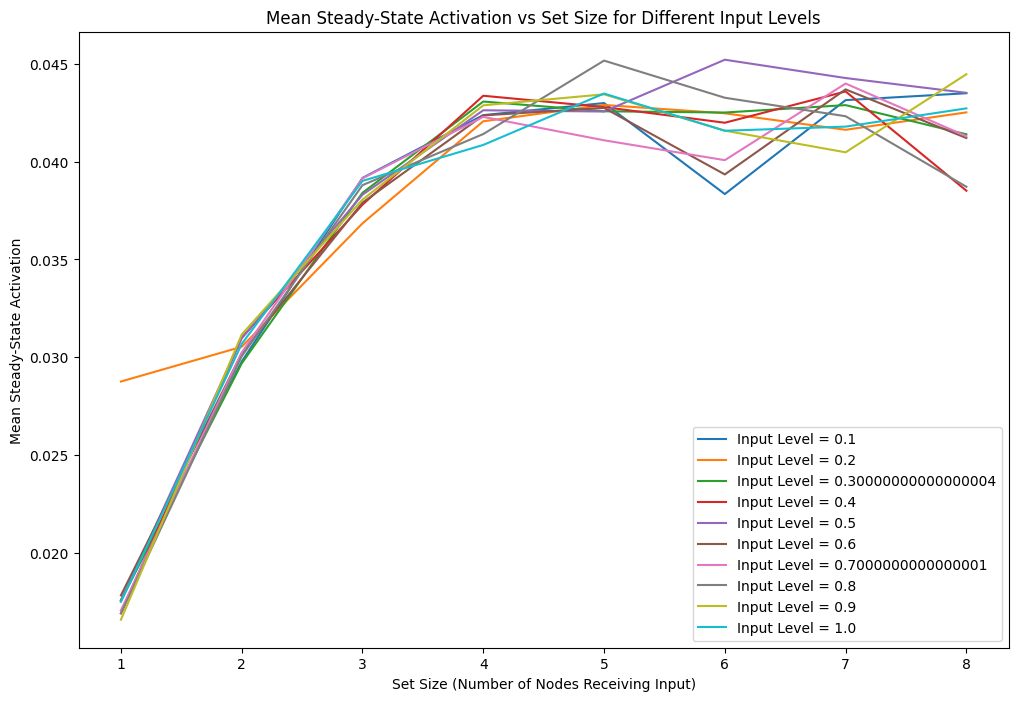

In [7]:
input_levels = np.arange(0.1, 1.1, 0.1)
betas = [0.15]
set_sizes = np.arange(1, 9, 1)

plt.figure(figsize=(12, 8))

for input_level in input_levels:
    network = ActivationNetwork(input_level=input_level)
    mean_activations = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_activations[i, j] = network.find_mean_activation(beta, set_size, num_simulations=1)

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_activations[i, :], label=f'Input Level = {input_level}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Mean Steady-State Activation')
plt.title('Mean Steady-State Activation vs Set Size for Different Input Levels')
plt.legend()
plt.show()

# SOA PLOT

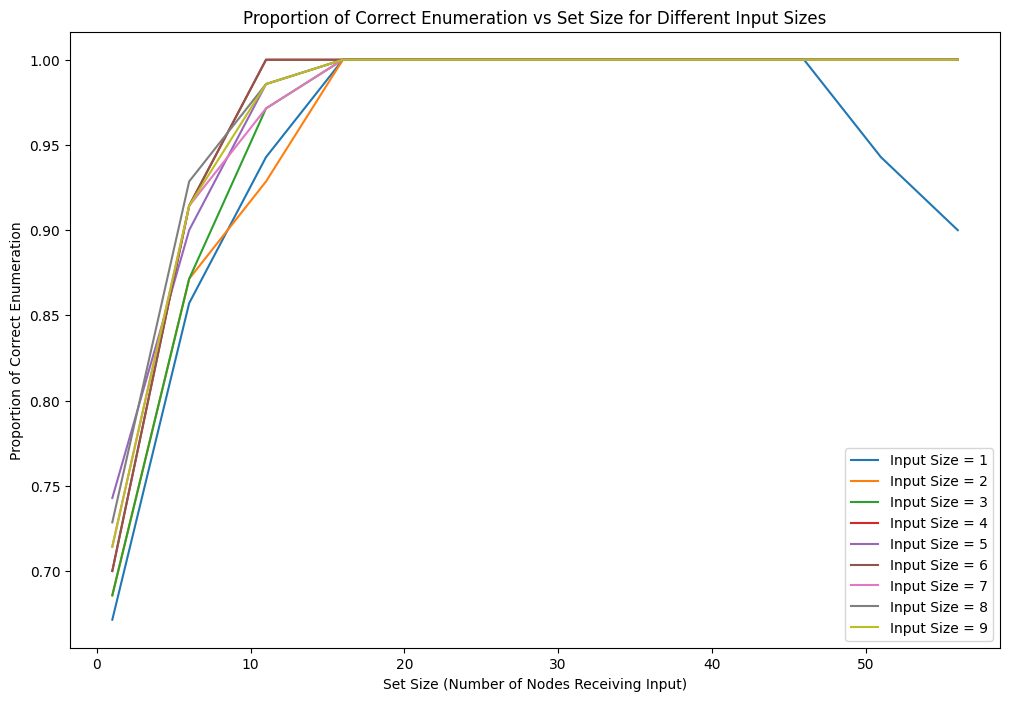

In [12]:
input_sizes = np.arange(1, 10, 1)
betas = [0.01]
set_sizes = np.arange(1, 61, 5)

plt.figure(figsize=(12, 8))

for input_size in input_sizes:
    network = ActivationNetwork(input_size=input_size)
    mean_correct_enumeration = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_correct_enumeration[i, j] = 1 - network.find_mean_hamming_distance(beta, set_size, num_simulations=1) / network.N

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_correct_enumeration[i, :], label=f'Input Size = {input_size}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Proportion of Correct Enumeration')
plt.title('Proportion of Correct Enumeration vs Set Size for Different Input Sizes')
plt.legend()
plt.show()

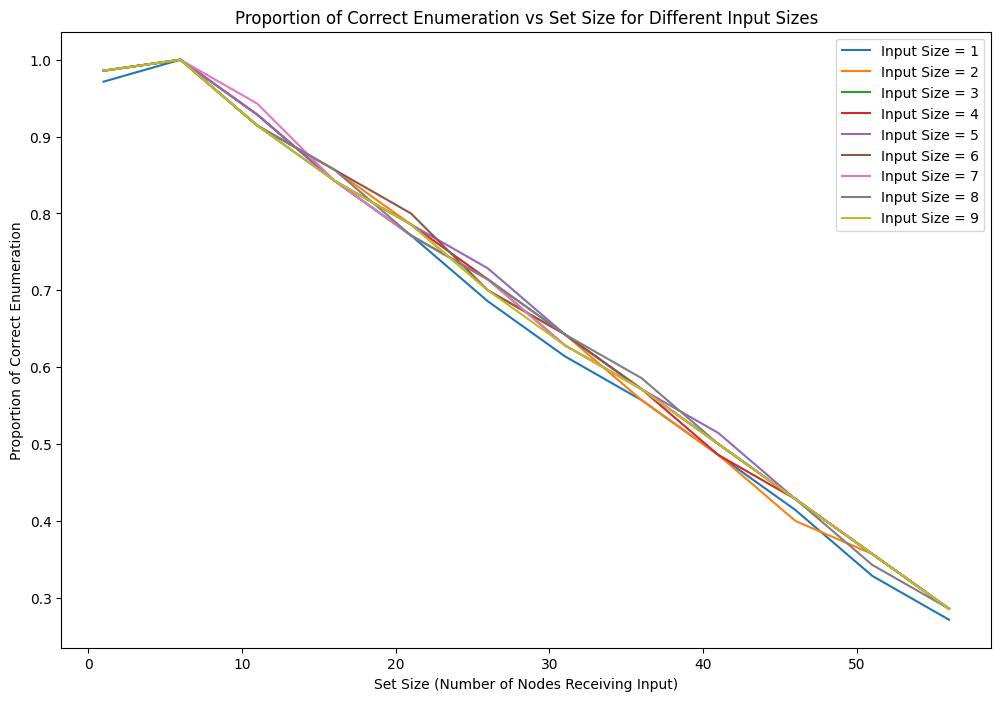

In [15]:
input_sizes = np.arange(1, 10, 1)
betas = [0.1]
set_sizes = np.arange(1, 61, 5)

plt.figure(figsize=(12, 8))

for input_size in input_sizes:
    network = ActivationNetwork(input_size=input_size)
    mean_correct_enumeration = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_correct_enumeration[i, j] = 1 - network.find_mean_hamming_distance(beta, set_size, num_simulations=1) / network.N

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_correct_enumeration[i, :], label=f'Input Size = {input_size}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Proportion of Correct Enumeration')
plt.title('Proportion of Correct Enumeration vs Set Size for Different Input Sizes')
plt.legend()
plt.show()

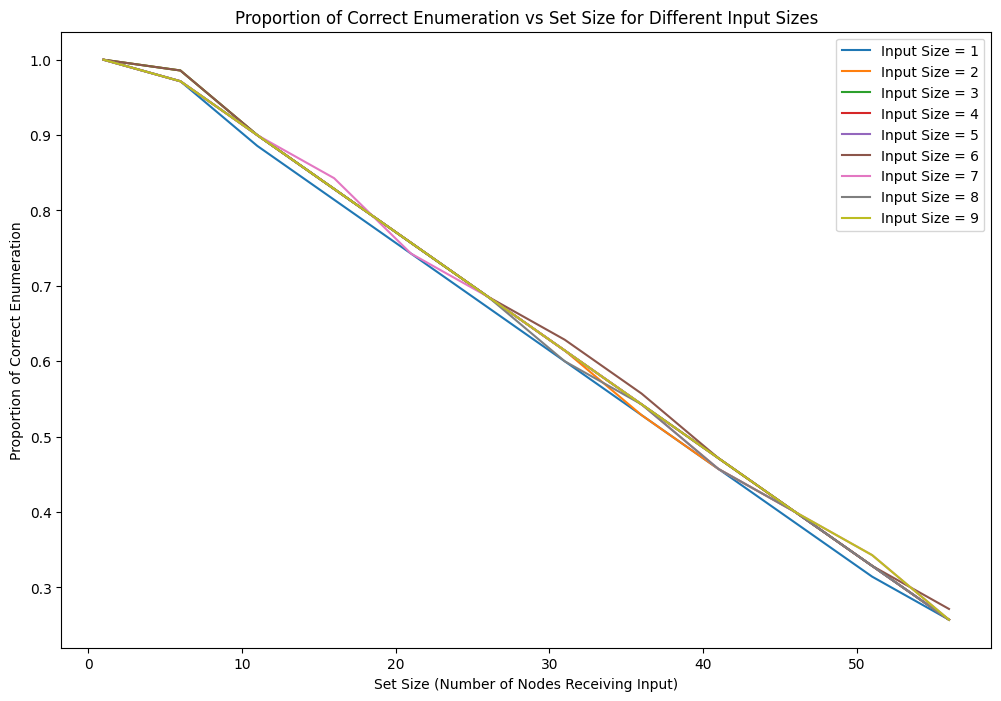

In [16]:
input_sizes = np.arange(1, 10, 1)
betas = [0.15]
set_sizes = np.arange(1, 61, 5)

plt.figure(figsize=(12, 8))

for input_size in input_sizes:
    network = ActivationNetwork(input_size=input_size)
    mean_correct_enumeration = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_correct_enumeration[i, j] = 1 - network.find_mean_hamming_distance(beta, set_size, num_simulations=1) / network.N

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_correct_enumeration[i, :], label=f'Input Size = {input_size}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Proportion of Correct Enumeration')
plt.title('Proportion of Correct Enumeration vs Set Size for Different Input Sizes')
plt.legend()
plt.show()